### Here are some example codes on how to conduct experiments describe in the paper

### Example 1: load pre-trained feature extractor, transfer to a small set of TUH Normal/Abnormal dataset. 

In [93]:
# This example shows how to load the pre-trained feature extractor parameters and how to pick certain numbers of layers to transfer
# The transfer learning results are compared with the resutls training the classifier from scratch 
# The small set of TUH Normal/Abnormal dataset has 30 normal recordings and 30 abnormal recordings 
# The total number of data samples is 11226
# We use cross validation KFOLD=5 to split the training set and testing set in each fold

In [94]:
#import necessary libraries
import torch
from torch import optim
from torch.utils import data
from torch import nn
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold

from downstream.TUH_edf import TUH_Normal_Abnormal
from models import Supervised_TUH

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
torch.manual_seed(0)

In [97]:
# define some training settings
batch_size = 32
num_workers = 16
epochs = 50
seed = 42 
learning_rate = 5e-5
model_path = './examples_res/tuh_all_ckp.pt'
normal_filename_path = './examples_res/tuh_normal.txt'
abnormal_filename_path = './examples_res/tuh_abnormal.txt'
layers_to_transfer = 3
folds = 5

In [98]:
def train_test_loop(train_loader, test_loader, model, n_epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

    #Run the training loop for defined number of epochs
    train_losses = []
    test_losses = []
    train_acces = []
    test_acces = []
    for epoch in range(1, n_epochs+1):
        train_loss, train_acc = _train_loss(model, train_loader, optimizer, criterion)
        train_losses.append(train_loss)
        train_acces.append(train_acc)
        test_loss, test_acc = _eval_loss(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_acces.append(test_acc)
        print(f'Epoch {epoch}, Train loss {train_loss:.4f} , Train Accuracy {train_acc:.4f}, Test loss {test_loss:.4f}, Test Accuracy {test_acc:.4f}')
        scheduler.step()

    return train_losses, test_losses, train_acces, test_acces
    
    
def _train_loss(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct, total = 0, 0
    
    for i, data in enumerate(tqdm(train_loader)):
        x, y = data
        x, y = x.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
        optimizer.zero_grad()
        out = model(x)
        
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
   
        predicted = out.data.to('cpu')
        predicted = predicted.reshape(-1).detach().numpy().round()
        target = y.to('cpu')
        target = target.reshape(-1).detach().numpy()
        total += len(target)
        correct += sum(p == t for p, t in zip(predicted, target))
    
    epoch_train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    
    return epoch_train_loss, train_acc


def _eval_loss(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader)):
            x, y = data           
            x, y = x.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
            out = model(x)
            
            loss = criterion(out, y)
            running_loss += loss.item()
            
            predicted = out.data.to('cpu') 
            predicted = predicted.reshape(-1).detach().numpy().round()
            y = y.to('cpu')
            y = y.reshape(-1).detach().numpy()
            total += len(y)
            correct += sum(p == t for p, t in zip(predicted, y))
            
        epoch_test_loss = running_loss / len(test_loader)
        test_acc = correct / total
        

    return epoch_test_loss, test_acc

In [99]:
import matplotlib.pyplot as plt
def _plot_losses(train_losses, test_losses, title='train and test losses'):
    plt.plot(train_losses, label='train_loss')
    plt.plot(test_losses, label='test_loss')
    plt.title(title)
    plt.legend()
    plt.show()

def _plot_acces(train_acces, test_acces, title='train and test acces'):
    plt.plot(train_acces, label='train_acc')
    plt.plot(test_acces, label='test_acc')
    plt.title(title)
    plt.legend()
    plt.show()

In [100]:
def transfer_learning():
    
    #Load Dataset
    dataset = TUH_Normal_Abnormal(normal_filename=normal_filename_path, abnormal_filename =abnormal_filename_path)
    
    
    kfold = KFold(n_splits=folds, shuffle=True)
    
    results = {}
    
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        print(f'Fold = {fold + 1}')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        
        train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size= batch_size, sampler=test_subsampler)
        
        #Initial model 
        model = Supervised_TUH()

        #Load pre-trained parameters
        pretrained_dict = torch.load(model_path) 
        pretrained_param_names = list(pretrained_dict.keys())
        model_dict = model.state_dict()
        model_param_names = list(model_dict.keys())

        # Load the first three layers' parameters
        # Note: One layer here corresponds to 4 layers in the model, they are  ... layers
        for i, _ in enumerate(pretrained_param_names[:layers_to_transfer * 4]):
            model_dict[model_param_names[i]] = pretrained_dict[pretrained_param_names[i]]
        
        model.load_state_dict(model_dict)
            
        model.to(device)
    
        train_losses, test_losses, train_acces, test_acces = train_test_loop(train_loader, test_loader, model, n_epochs=epochs, lr=learning_rate)
        results[fold] = max(test_acces)
        
        _plot_losses(train_losses, test_losses)
        _plot_acces(train_acces, test_acces)
        
    sum = 0.0    
    for key, value in results.items():
        print(f'Fold {key}: {value} %\n')
        sum += value
    print(f'Average: {sum/len(results.items())} %\n') 
    

In [101]:
def train_from_sratch():
    #Load Dataset
    dataset = TUH_Normal_Abnormal(normal_filename=normal_filename_path, abnormal_filename =abnormal_filename_path)
    
    
    kfold = KFold(n_splits=folds, shuffle=True)
    
    results = {}
    
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        print(f'Fold = {fold + 1}')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        
        train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size= batch_size, sampler=test_subsampler)
        
        #Initial model 
        model = Supervised_TUH()
        model.to(device)
    
        train_losses, test_losses, train_acces, test_acces = train_test_loop(train_loader, test_loader, model, n_epochs=epochs, lr=learning_rate)
        results[fold] = max(test_acces)
        
        _plot_losses(train_losses, test_losses)
        _plot_acces(train_acces, test_acces)
        
    sum = 0.0    
    for key, value in results.items():
        print(f'Fold {key}: {value} %\n')
        sum += value
    print(f'Average: {sum/len(results.items())} %\n') 



  0%|          | 1/281 [00:00<00:37,  7.44it/s]

(11226, 1, 19, 1500)
(11226, 1)
Fold = 1


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 1, Train loss 0.7166 , Train Accuracy 0.5245, Test loss 0.7619, Test Accuracy 0.5436


  0%|          | 1/281 [00:00<00:33,  8.35it/s]

Epoch 2, Train loss 0.6873 , Train Accuracy 0.5678, Test loss 0.8248, Test Accuracy 0.5485


  0%|          | 1/281 [00:00<00:33,  8.41it/s]

Epoch 3, Train loss 0.6754 , Train Accuracy 0.5824, Test loss 0.6559, Test Accuracy 0.6238


  0%|          | 1/281 [00:00<00:34,  8.17it/s]

Epoch 4, Train loss 0.6681 , Train Accuracy 0.5894, Test loss 0.6291, Test Accuracy 0.6545


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 5, Train loss 0.6572 , Train Accuracy 0.6052, Test loss 0.6259, Test Accuracy 0.6714


  0%|          | 1/281 [00:00<00:33,  8.31it/s]

Epoch 6, Train loss 0.6488 , Train Accuracy 0.6145, Test loss 0.6167, Test Accuracy 0.6883


  0%|          | 1/281 [00:00<00:35,  7.98it/s]

Epoch 7, Train loss 0.6396 , Train Accuracy 0.6322, Test loss 0.6203, Test Accuracy 0.6825


  0%|          | 1/281 [00:00<00:34,  8.00it/s]

Epoch 8, Train loss 0.6327 , Train Accuracy 0.6439, Test loss 0.6139, Test Accuracy 0.6950


  0%|          | 1/281 [00:00<00:33,  8.35it/s]

Epoch 9, Train loss 0.6303 , Train Accuracy 0.6469, Test loss 0.6197, Test Accuracy 0.6901


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 10, Train loss 0.6296 , Train Accuracy 0.6503, Test loss 0.6254, Test Accuracy 0.7124


  0%|          | 1/281 [00:00<00:34,  8.09it/s]

Epoch 11, Train loss 0.6195 , Train Accuracy 0.6557, Test loss 0.6116, Test Accuracy 0.7048


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 12, Train loss 0.6214 , Train Accuracy 0.6575, Test loss 0.6226, Test Accuracy 0.6977


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 13, Train loss 0.6104 , Train Accuracy 0.6687, Test loss 0.6228, Test Accuracy 0.7137


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 14, Train loss 0.6099 , Train Accuracy 0.6723, Test loss 0.6128, Test Accuracy 0.7128


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 15, Train loss 0.6091 , Train Accuracy 0.6719, Test loss 0.6484, Test Accuracy 0.7048


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 16, Train loss 0.6069 , Train Accuracy 0.6732, Test loss 0.6246, Test Accuracy 0.7128


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 17, Train loss 0.5994 , Train Accuracy 0.6741, Test loss 0.6119, Test Accuracy 0.7231


  0%|          | 1/281 [00:00<00:35,  7.89it/s]

Epoch 18, Train loss 0.5960 , Train Accuracy 0.6885, Test loss 0.6200, Test Accuracy 0.7146


  0%|          | 1/281 [00:00<00:34,  8.13it/s]

Epoch 19, Train loss 0.5937 , Train Accuracy 0.6915, Test loss 0.6170, Test Accuracy 0.7137


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 20, Train loss 0.5915 , Train Accuracy 0.6915, Test loss 0.6037, Test Accuracy 0.7217


  0%|          | 1/281 [00:00<00:33,  8.35it/s]

Epoch 21, Train loss 0.5875 , Train Accuracy 0.6918, Test loss 0.6085, Test Accuracy 0.7271


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 22, Train loss 0.5870 , Train Accuracy 0.6923, Test loss 0.5987, Test Accuracy 0.7262


  0%|          | 1/281 [00:00<00:33,  8.26it/s]

Epoch 23, Train loss 0.5867 , Train Accuracy 0.6970, Test loss 0.6064, Test Accuracy 0.7244


  0%|          | 1/281 [00:00<00:34,  8.20it/s]

Epoch 24, Train loss 0.5850 , Train Accuracy 0.6901, Test loss 0.6150, Test Accuracy 0.7244


  0%|          | 1/281 [00:00<00:33,  8.28it/s]

Epoch 25, Train loss 0.5792 , Train Accuracy 0.7004, Test loss 0.6072, Test Accuracy 0.7271


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 26, Train loss 0.5726 , Train Accuracy 0.7032, Test loss 0.5943, Test Accuracy 0.7346


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 27, Train loss 0.5744 , Train Accuracy 0.7065, Test loss 0.5902, Test Accuracy 0.7293


  0%|          | 1/281 [00:00<00:35,  7.97it/s]

Epoch 28, Train loss 0.5762 , Train Accuracy 0.7031, Test loss 0.5897, Test Accuracy 0.7297


  0%|          | 1/281 [00:00<00:35,  7.99it/s]

Epoch 29, Train loss 0.5645 , Train Accuracy 0.7104, Test loss 0.5779, Test Accuracy 0.7333


  0%|          | 1/281 [00:00<00:34,  8.02it/s]

Epoch 30, Train loss 0.5674 , Train Accuracy 0.7062, Test loss 0.5866, Test Accuracy 0.7382


  0%|          | 1/281 [00:00<00:33,  8.26it/s]

Epoch 31, Train loss 0.5666 , Train Accuracy 0.7088, Test loss 0.5841, Test Accuracy 0.7364


  0%|          | 1/281 [00:00<00:33,  8.25it/s]

Epoch 32, Train loss 0.5605 , Train Accuracy 0.7136, Test loss 0.5870, Test Accuracy 0.7373


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 33, Train loss 0.5675 , Train Accuracy 0.7120, Test loss 0.5772, Test Accuracy 0.7373


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 34, Train loss 0.5625 , Train Accuracy 0.7115, Test loss 0.5747, Test Accuracy 0.7449


  0%|          | 1/281 [00:00<00:34,  8.05it/s]

Epoch 35, Train loss 0.5576 , Train Accuracy 0.7218, Test loss 0.5837, Test Accuracy 0.7400


  0%|          | 1/281 [00:00<00:34,  8.05it/s]

Epoch 36, Train loss 0.5588 , Train Accuracy 0.7178, Test loss 0.5943, Test Accuracy 0.7320


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 37, Train loss 0.5579 , Train Accuracy 0.7164, Test loss 0.5799, Test Accuracy 0.7386


  0%|          | 1/281 [00:00<00:34,  8.21it/s]

Epoch 38, Train loss 0.5530 , Train Accuracy 0.7203, Test loss 0.5824, Test Accuracy 0.7400


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 39, Train loss 0.5523 , Train Accuracy 0.7173, Test loss 0.5657, Test Accuracy 0.7449


  0%|          | 1/281 [00:00<00:34,  8.13it/s]

Epoch 40, Train loss 0.5537 , Train Accuracy 0.7203, Test loss 0.5646, Test Accuracy 0.7382


  0%|          | 1/281 [00:00<00:33,  8.26it/s]

Epoch 41, Train loss 0.5488 , Train Accuracy 0.7277, Test loss 0.5725, Test Accuracy 0.7418


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 42, Train loss 0.5505 , Train Accuracy 0.7187, Test loss 0.5811, Test Accuracy 0.7378


  0%|          | 1/281 [00:00<00:36,  7.68it/s]

Epoch 43, Train loss 0.5458 , Train Accuracy 0.7238, Test loss 0.5930, Test Accuracy 0.7395


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 44, Train loss 0.5489 , Train Accuracy 0.7245, Test loss 0.5734, Test Accuracy 0.7435


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 45, Train loss 0.5410 , Train Accuracy 0.7306, Test loss 0.5804, Test Accuracy 0.7373


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 46, Train loss 0.5415 , Train Accuracy 0.7293, Test loss 0.5807, Test Accuracy 0.7440


  0%|          | 1/281 [00:00<00:33,  8.37it/s]

Epoch 47, Train loss 0.5434 , Train Accuracy 0.7264, Test loss 0.5644, Test Accuracy 0.7458


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 48, Train loss 0.5447 , Train Accuracy 0.7276, Test loss 0.5630, Test Accuracy 0.7498


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 49, Train loss 0.5391 , Train Accuracy 0.7306, Test loss 0.5790, Test Accuracy 0.7493


100%|██████████| 71/71 [00:01<00:00, 44.20it/s]


Epoch 50, Train loss 0.5340 , Train Accuracy 0.7347, Test loss 0.5668, Test Accuracy 0.7520


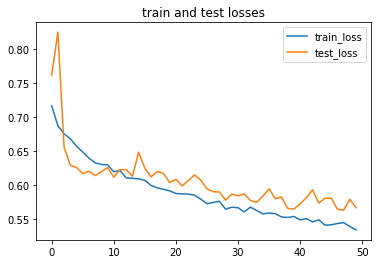

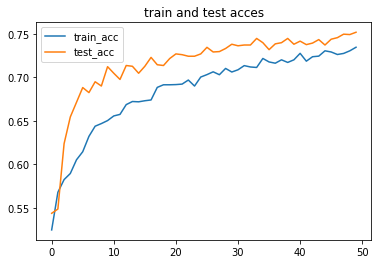

  0%|          | 0/281 [00:00<?, ?it/s]

Fold = 2


  0%|          | 1/281 [00:00<00:34,  8.17it/s]

Epoch 1, Train loss 0.7000 , Train Accuracy 0.5331, Test loss 0.6675, Test Accuracy 0.5969


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 2, Train loss 0.6887 , Train Accuracy 0.5519, Test loss 0.6450, Test Accuracy 0.6281


  0%|          | 1/281 [00:00<00:33,  8.35it/s]

Epoch 3, Train loss 0.6774 , Train Accuracy 0.5750, Test loss 0.6389, Test Accuracy 0.6437


  0%|          | 1/281 [00:00<00:35,  7.98it/s]

Epoch 4, Train loss 0.6705 , Train Accuracy 0.5852, Test loss 0.6219, Test Accuracy 0.6628


  0%|          | 1/281 [00:00<00:33,  8.29it/s]

Epoch 5, Train loss 0.6644 , Train Accuracy 0.5997, Test loss 0.6485, Test Accuracy 0.6459


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 6, Train loss 0.6593 , Train Accuracy 0.6019, Test loss 0.6333, Test Accuracy 0.6664


  0%|          | 1/281 [00:00<00:34,  8.04it/s]

Epoch 7, Train loss 0.6546 , Train Accuracy 0.6107, Test loss 0.6381, Test Accuracy 0.6699


  0%|          | 1/281 [00:00<00:34,  8.18it/s]

Epoch 8, Train loss 0.6518 , Train Accuracy 0.6154, Test loss 0.6123, Test Accuracy 0.6878


  0%|          | 1/281 [00:00<00:34,  8.02it/s]

Epoch 9, Train loss 0.6435 , Train Accuracy 0.6296, Test loss 0.6118, Test Accuracy 0.6855


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 10, Train loss 0.6409 , Train Accuracy 0.6358, Test loss 0.7278, Test Accuracy 0.6298


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 11, Train loss 0.6374 , Train Accuracy 0.6361, Test loss 0.6143, Test Accuracy 0.6891


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 12, Train loss 0.6311 , Train Accuracy 0.6513, Test loss 0.6419, Test Accuracy 0.6788


  0%|          | 1/281 [00:00<00:34,  8.23it/s]

Epoch 13, Train loss 0.6342 , Train Accuracy 0.6449, Test loss 0.6566, Test Accuracy 0.6713


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 14, Train loss 0.6252 , Train Accuracy 0.6537, Test loss 0.6159, Test Accuracy 0.6949


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 15, Train loss 0.6242 , Train Accuracy 0.6528, Test loss 0.5941, Test Accuracy 0.7091


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 16, Train loss 0.6181 , Train Accuracy 0.6632, Test loss 0.6012, Test Accuracy 0.7118


  0%|          | 1/281 [00:00<00:34,  8.09it/s]

Epoch 17, Train loss 0.6138 , Train Accuracy 0.6645, Test loss 0.6298, Test Accuracy 0.6931


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 18, Train loss 0.6164 , Train Accuracy 0.6625, Test loss 0.6075, Test Accuracy 0.7189


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 19, Train loss 0.6122 , Train Accuracy 0.6679, Test loss 0.5956, Test Accuracy 0.7203


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 20, Train loss 0.6068 , Train Accuracy 0.6733, Test loss 0.6015, Test Accuracy 0.7234


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 21, Train loss 0.6051 , Train Accuracy 0.6790, Test loss 0.5972, Test Accuracy 0.7185


  0%|          | 1/281 [00:00<00:33,  8.25it/s]

Epoch 22, Train loss 0.6064 , Train Accuracy 0.6740, Test loss 0.6017, Test Accuracy 0.7198


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 23, Train loss 0.6021 , Train Accuracy 0.6838, Test loss 0.6667, Test Accuracy 0.6904


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 24, Train loss 0.6026 , Train Accuracy 0.6790, Test loss 0.6076, Test Accuracy 0.7310


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 25, Train loss 0.5957 , Train Accuracy 0.6850, Test loss 0.5881, Test Accuracy 0.7332


  0%|          | 1/281 [00:00<00:34,  8.21it/s]

Epoch 26, Train loss 0.5976 , Train Accuracy 0.6824, Test loss 0.6029, Test Accuracy 0.7252


  0%|          | 1/281 [00:00<00:34,  8.05it/s]

Epoch 27, Train loss 0.5971 , Train Accuracy 0.6802, Test loss 0.5870, Test Accuracy 0.7363


  0%|          | 1/281 [00:00<00:34,  8.13it/s]

Epoch 28, Train loss 0.5918 , Train Accuracy 0.6875, Test loss 0.6223, Test Accuracy 0.7100


  0%|          | 1/281 [00:00<00:34,  8.09it/s]

Epoch 29, Train loss 0.5911 , Train Accuracy 0.6896, Test loss 0.6092, Test Accuracy 0.7314


  0%|          | 1/281 [00:00<00:33,  8.33it/s]

Epoch 30, Train loss 0.5876 , Train Accuracy 0.6951, Test loss 0.5775, Test Accuracy 0.7336


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 31, Train loss 0.5867 , Train Accuracy 0.6954, Test loss 0.5971, Test Accuracy 0.7265


  0%|          | 1/281 [00:00<00:34,  8.03it/s]

Epoch 32, Train loss 0.5846 , Train Accuracy 0.6988, Test loss 0.5909, Test Accuracy 0.7372


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 33, Train loss 0.5818 , Train Accuracy 0.6995, Test loss 0.5843, Test Accuracy 0.7430


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 34, Train loss 0.5767 , Train Accuracy 0.7018, Test loss 0.5877, Test Accuracy 0.7425


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 35, Train loss 0.5761 , Train Accuracy 0.7050, Test loss 0.5846, Test Accuracy 0.7452


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 36, Train loss 0.5768 , Train Accuracy 0.7014, Test loss 0.5964, Test Accuracy 0.7354


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 37, Train loss 0.5736 , Train Accuracy 0.7059, Test loss 0.5884, Test Accuracy 0.7412


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 38, Train loss 0.5674 , Train Accuracy 0.7082, Test loss 0.5637, Test Accuracy 0.7416


  0%|          | 1/281 [00:00<00:33,  8.35it/s]

Epoch 39, Train loss 0.5686 , Train Accuracy 0.7077, Test loss 0.5720, Test Accuracy 0.7408


  0%|          | 1/281 [00:00<00:33,  8.30it/s]

Epoch 40, Train loss 0.5675 , Train Accuracy 0.7099, Test loss 0.5688, Test Accuracy 0.7381


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 41, Train loss 0.5639 , Train Accuracy 0.7153, Test loss 0.5679, Test Accuracy 0.7452


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 42, Train loss 0.5702 , Train Accuracy 0.7104, Test loss 0.5663, Test Accuracy 0.7443


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 43, Train loss 0.5610 , Train Accuracy 0.7117, Test loss 0.5856, Test Accuracy 0.7470


  0%|          | 1/281 [00:00<00:35,  7.98it/s]

Epoch 44, Train loss 0.5599 , Train Accuracy 0.7146, Test loss 0.5668, Test Accuracy 0.7457


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 45, Train loss 0.5587 , Train Accuracy 0.7166, Test loss 0.5767, Test Accuracy 0.7461


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 46, Train loss 0.5569 , Train Accuracy 0.7180, Test loss 0.5645, Test Accuracy 0.7465


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 47, Train loss 0.5607 , Train Accuracy 0.7152, Test loss 0.5629, Test Accuracy 0.7461


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 48, Train loss 0.5578 , Train Accuracy 0.7175, Test loss 0.5592, Test Accuracy 0.7519


  0%|          | 1/281 [00:00<00:34,  8.23it/s]

Epoch 49, Train loss 0.5555 , Train Accuracy 0.7215, Test loss 0.5872, Test Accuracy 0.7443


100%|██████████| 71/71 [00:01<00:00, 45.72it/s]


Epoch 50, Train loss 0.5542 , Train Accuracy 0.7156, Test loss 0.5801, Test Accuracy 0.7434


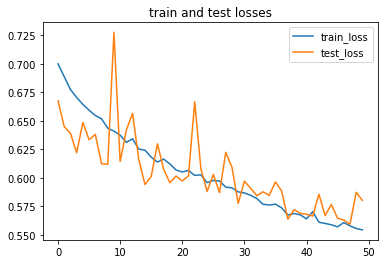

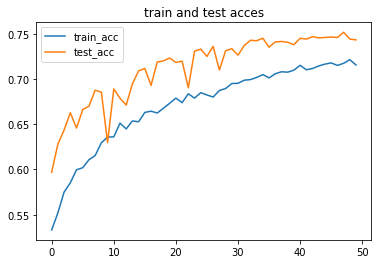

  0%|          | 0/281 [00:00<?, ?it/s]

Fold = 3


  0%|          | 1/281 [00:00<00:33,  8.28it/s]

Epoch 1, Train loss 0.7073 , Train Accuracy 0.5337, Test loss 0.6628, Test Accuracy 0.5973


  0%|          | 1/281 [00:00<00:34,  8.13it/s]

Epoch 2, Train loss 0.6791 , Train Accuracy 0.5703, Test loss 0.6428, Test Accuracy 0.6290


  0%|          | 1/281 [00:00<00:35,  7.99it/s]

Epoch 3, Train loss 0.6700 , Train Accuracy 0.5858, Test loss 0.6832, Test Accuracy 0.6018


  0%|          | 1/281 [00:00<00:35,  7.89it/s]

Epoch 4, Train loss 0.6579 , Train Accuracy 0.6080, Test loss 0.6316, Test Accuracy 0.6530


  0%|          | 1/281 [00:00<00:35,  7.85it/s]

Epoch 5, Train loss 0.6542 , Train Accuracy 0.6103, Test loss 0.6262, Test Accuracy 0.6468


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 6, Train loss 0.6424 , Train Accuracy 0.6282, Test loss 0.6193, Test Accuracy 0.6664


  0%|          | 1/281 [00:00<00:34,  8.23it/s]

Epoch 7, Train loss 0.6392 , Train Accuracy 0.6341, Test loss 0.6408, Test Accuracy 0.6561


  0%|          | 1/281 [00:00<00:33,  8.24it/s]

Epoch 8, Train loss 0.6308 , Train Accuracy 0.6451, Test loss 0.6309, Test Accuracy 0.6619


  0%|          | 1/281 [00:00<00:34,  8.23it/s]

Epoch 9, Train loss 0.6307 , Train Accuracy 0.6489, Test loss 0.6060, Test Accuracy 0.6851


  0%|          | 1/281 [00:00<00:34,  8.21it/s]

Epoch 10, Train loss 0.6204 , Train Accuracy 0.6597, Test loss 0.6207, Test Accuracy 0.6748


  0%|          | 1/281 [00:00<00:34,  8.20it/s]

Epoch 11, Train loss 0.6171 , Train Accuracy 0.6587, Test loss 0.6186, Test Accuracy 0.6891


  0%|          | 1/281 [00:00<00:33,  8.26it/s]

Epoch 12, Train loss 0.6138 , Train Accuracy 0.6707, Test loss 0.6227, Test Accuracy 0.6784


  0%|          | 1/281 [00:00<00:34,  8.09it/s]

Epoch 13, Train loss 0.6112 , Train Accuracy 0.6703, Test loss 0.6169, Test Accuracy 0.7011


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 14, Train loss 0.6060 , Train Accuracy 0.6764, Test loss 0.6297, Test Accuracy 0.6797


  0%|          | 1/281 [00:00<00:33,  8.28it/s]

Epoch 15, Train loss 0.6092 , Train Accuracy 0.6732, Test loss 0.6183, Test Accuracy 0.7038


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 16, Train loss 0.6004 , Train Accuracy 0.6770, Test loss 0.6510, Test Accuracy 0.6918


  0%|          | 1/281 [00:00<00:35,  7.95it/s]

Epoch 17, Train loss 0.6019 , Train Accuracy 0.6822, Test loss 0.6812, Test Accuracy 0.6784


  0%|          | 1/281 [00:00<00:33,  8.35it/s]

Epoch 18, Train loss 0.5975 , Train Accuracy 0.6864, Test loss 0.6298, Test Accuracy 0.6882


  0%|          | 1/281 [00:00<00:33,  8.31it/s]

Epoch 19, Train loss 0.5950 , Train Accuracy 0.6888, Test loss 0.6068, Test Accuracy 0.7096


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 20, Train loss 0.5914 , Train Accuracy 0.6927, Test loss 0.6720, Test Accuracy 0.6757


  0%|          | 1/281 [00:00<00:34,  8.17it/s]

Epoch 21, Train loss 0.5898 , Train Accuracy 0.6931, Test loss 0.6075, Test Accuracy 0.7065


  0%|          | 1/281 [00:00<00:33,  8.33it/s]

Epoch 22, Train loss 0.5875 , Train Accuracy 0.7026, Test loss 0.5934, Test Accuracy 0.7122


  0%|          | 1/281 [00:00<00:33,  8.34it/s]

Epoch 23, Train loss 0.5799 , Train Accuracy 0.7005, Test loss 0.5935, Test Accuracy 0.7158


  0%|          | 1/281 [00:00<00:33,  8.34it/s]

Epoch 24, Train loss 0.5830 , Train Accuracy 0.7000, Test loss 0.6363, Test Accuracy 0.6967


  0%|          | 1/281 [00:00<00:34,  8.17it/s]

Epoch 25, Train loss 0.5788 , Train Accuracy 0.7033, Test loss 0.5967, Test Accuracy 0.7225


  0%|          | 1/281 [00:00<00:34,  8.06it/s]

Epoch 26, Train loss 0.5730 , Train Accuracy 0.7037, Test loss 0.6006, Test Accuracy 0.7216


  0%|          | 1/281 [00:00<00:34,  8.18it/s]

Epoch 27, Train loss 0.5755 , Train Accuracy 0.7094, Test loss 0.6031, Test Accuracy 0.7238


  0%|          | 1/281 [00:00<00:35,  7.79it/s]

Epoch 28, Train loss 0.5727 , Train Accuracy 0.7097, Test loss 0.5833, Test Accuracy 0.7269


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 29, Train loss 0.5688 , Train Accuracy 0.7124, Test loss 0.5976, Test Accuracy 0.7274


  0%|          | 1/281 [00:00<00:34,  8.19it/s]

Epoch 30, Train loss 0.5691 , Train Accuracy 0.7161, Test loss 0.5843, Test Accuracy 0.7283


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 31, Train loss 0.5683 , Train Accuracy 0.7141, Test loss 0.5882, Test Accuracy 0.7301


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 32, Train loss 0.5615 , Train Accuracy 0.7153, Test loss 0.6113, Test Accuracy 0.7167


  0%|          | 1/281 [00:00<00:34,  8.06it/s]

Epoch 33, Train loss 0.5616 , Train Accuracy 0.7136, Test loss 0.5944, Test Accuracy 0.7305


  0%|          | 1/281 [00:00<00:34,  8.06it/s]

Epoch 34, Train loss 0.5616 , Train Accuracy 0.7161, Test loss 0.5813, Test Accuracy 0.7287


  0%|          | 1/281 [00:00<00:34,  8.02it/s]

Epoch 35, Train loss 0.5570 , Train Accuracy 0.7143, Test loss 0.6067, Test Accuracy 0.7403


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 36, Train loss 0.5635 , Train Accuracy 0.7174, Test loss 0.5877, Test Accuracy 0.7318


  0%|          | 1/281 [00:00<00:33,  8.33it/s]

Epoch 37, Train loss 0.5530 , Train Accuracy 0.7241, Test loss 0.6138, Test Accuracy 0.7341


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 38, Train loss 0.5556 , Train Accuracy 0.7235, Test loss 0.6421, Test Accuracy 0.7216


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 39, Train loss 0.5509 , Train Accuracy 0.7235, Test loss 0.6274, Test Accuracy 0.7372


  0%|          | 1/281 [00:00<00:34,  8.13it/s]

Epoch 40, Train loss 0.5500 , Train Accuracy 0.7242, Test loss 0.5949, Test Accuracy 0.7403


  0%|          | 1/281 [00:00<00:33,  8.25it/s]

Epoch 41, Train loss 0.5499 , Train Accuracy 0.7229, Test loss 0.5916, Test Accuracy 0.7318


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 42, Train loss 0.5480 , Train Accuracy 0.7354, Test loss 0.5971, Test Accuracy 0.7399


  0%|          | 1/281 [00:00<00:34,  8.13it/s]

Epoch 43, Train loss 0.5476 , Train Accuracy 0.7318, Test loss 0.5945, Test Accuracy 0.7425


  0%|          | 1/281 [00:00<00:33,  8.25it/s]

Epoch 44, Train loss 0.5448 , Train Accuracy 0.7343, Test loss 0.5993, Test Accuracy 0.7434


  0%|          | 1/281 [00:00<00:34,  8.18it/s]

Epoch 45, Train loss 0.5461 , Train Accuracy 0.7278, Test loss 0.6252, Test Accuracy 0.7336


  0%|          | 1/281 [00:00<00:34,  8.19it/s]

Epoch 46, Train loss 0.5440 , Train Accuracy 0.7337, Test loss 0.5875, Test Accuracy 0.7488


  0%|          | 1/281 [00:00<00:35,  7.99it/s]

Epoch 47, Train loss 0.5401 , Train Accuracy 0.7329, Test loss 0.5844, Test Accuracy 0.7461


  0%|          | 1/281 [00:00<00:34,  8.18it/s]

Epoch 48, Train loss 0.5391 , Train Accuracy 0.7333, Test loss 0.5893, Test Accuracy 0.7430


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 49, Train loss 0.5359 , Train Accuracy 0.7386, Test loss 0.5830, Test Accuracy 0.7479


100%|██████████| 71/71 [00:01<00:00, 43.86it/s]


Epoch 50, Train loss 0.5371 , Train Accuracy 0.7382, Test loss 0.5865, Test Accuracy 0.7474


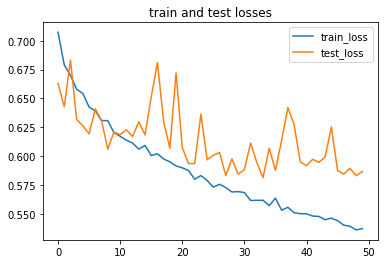

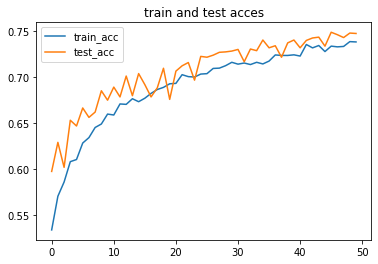

  0%|          | 0/281 [00:00<?, ?it/s]

Fold = 4


  0%|          | 1/281 [00:00<00:33,  8.24it/s]

Epoch 1, Train loss 0.7007 , Train Accuracy 0.5321, Test loss 0.6494, Test Accuracy 0.6241


  0%|          | 1/281 [00:00<00:35,  7.96it/s]

Epoch 2, Train loss 0.6840 , Train Accuracy 0.5556, Test loss 0.6384, Test Accuracy 0.6388


  0%|          | 1/281 [00:00<00:33,  8.28it/s]

Epoch 3, Train loss 0.6698 , Train Accuracy 0.5850, Test loss 0.6400, Test Accuracy 0.6423


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 4, Train loss 0.6634 , Train Accuracy 0.5911, Test loss 0.6299, Test Accuracy 0.6561


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 5, Train loss 0.6568 , Train Accuracy 0.6120, Test loss 0.6279, Test Accuracy 0.6686


  0%|          | 1/281 [00:00<00:35,  7.92it/s]

Epoch 6, Train loss 0.6511 , Train Accuracy 0.6192, Test loss 0.6632, Test Accuracy 0.6423


  0%|          | 1/281 [00:00<00:34,  8.20it/s]

Epoch 7, Train loss 0.6389 , Train Accuracy 0.6338, Test loss 0.6278, Test Accuracy 0.6793


  0%|          | 1/281 [00:00<00:33,  8.25it/s]

Epoch 8, Train loss 0.6359 , Train Accuracy 0.6417, Test loss 0.6258, Test Accuracy 0.6820


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 9, Train loss 0.6317 , Train Accuracy 0.6504, Test loss 0.6233, Test Accuracy 0.6824


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 10, Train loss 0.6273 , Train Accuracy 0.6548, Test loss 0.6459, Test Accuracy 0.6748


  0%|          | 1/281 [00:00<00:33,  8.30it/s]

Epoch 11, Train loss 0.6220 , Train Accuracy 0.6591, Test loss 0.6359, Test Accuracy 0.6891


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 12, Train loss 0.6179 , Train Accuracy 0.6681, Test loss 0.6252, Test Accuracy 0.6913


  0%|          | 1/281 [00:00<00:34,  8.17it/s]

Epoch 13, Train loss 0.6175 , Train Accuracy 0.6665, Test loss 0.6298, Test Accuracy 0.6878


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 14, Train loss 0.6147 , Train Accuracy 0.6716, Test loss 0.6540, Test Accuracy 0.6873


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 15, Train loss 0.6090 , Train Accuracy 0.6767, Test loss 0.6558, Test Accuracy 0.6895


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 16, Train loss 0.6047 , Train Accuracy 0.6836, Test loss 0.6218, Test Accuracy 0.6949


  0%|          | 1/281 [00:00<00:34,  8.05it/s]

Epoch 17, Train loss 0.6021 , Train Accuracy 0.6836, Test loss 0.6498, Test Accuracy 0.6949


  0%|          | 1/281 [00:00<00:34,  8.19it/s]

Epoch 18, Train loss 0.5999 , Train Accuracy 0.6809, Test loss 0.6628, Test Accuracy 0.6944


  0%|          | 1/281 [00:00<00:34,  8.13it/s]

Epoch 19, Train loss 0.5977 , Train Accuracy 0.6846, Test loss 0.6507, Test Accuracy 0.6940


  0%|          | 1/281 [00:00<00:33,  8.28it/s]

Epoch 20, Train loss 0.5919 , Train Accuracy 0.6916, Test loss 0.6597, Test Accuracy 0.6958


  0%|          | 1/281 [00:00<00:33,  8.31it/s]

Epoch 21, Train loss 0.5905 , Train Accuracy 0.6925, Test loss 0.6750, Test Accuracy 0.6953


  0%|          | 1/281 [00:00<00:34,  8.05it/s]

Epoch 22, Train loss 0.5859 , Train Accuracy 0.6997, Test loss 0.6630, Test Accuracy 0.7051


  0%|          | 1/281 [00:00<00:34,  8.13it/s]

Epoch 23, Train loss 0.5882 , Train Accuracy 0.6946, Test loss 0.6609, Test Accuracy 0.7024


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 24, Train loss 0.5872 , Train Accuracy 0.6946, Test loss 0.6569, Test Accuracy 0.7082


  0%|          | 1/281 [00:00<00:34,  8.09it/s]

Epoch 25, Train loss 0.5793 , Train Accuracy 0.6999, Test loss 0.6605, Test Accuracy 0.7096


  0%|          | 1/281 [00:00<00:35,  7.98it/s]

Epoch 26, Train loss 0.5815 , Train Accuracy 0.7007, Test loss 0.6583, Test Accuracy 0.7100


  0%|          | 1/281 [00:00<00:35,  7.90it/s]

Epoch 27, Train loss 0.5716 , Train Accuracy 0.7088, Test loss 0.6478, Test Accuracy 0.7096


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 28, Train loss 0.5803 , Train Accuracy 0.7033, Test loss 0.6228, Test Accuracy 0.7131


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 29, Train loss 0.5750 , Train Accuracy 0.7072, Test loss 0.6305, Test Accuracy 0.7127


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 30, Train loss 0.5735 , Train Accuracy 0.7042, Test loss 0.6722, Test Accuracy 0.7078


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 31, Train loss 0.5692 , Train Accuracy 0.7091, Test loss 0.6606, Test Accuracy 0.7091


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 32, Train loss 0.5684 , Train Accuracy 0.7099, Test loss 0.6342, Test Accuracy 0.7122


  0%|          | 1/281 [00:00<00:34,  8.05it/s]

Epoch 33, Train loss 0.5718 , Train Accuracy 0.7097, Test loss 0.7069, Test Accuracy 0.6953


  0%|          | 1/281 [00:00<00:34,  8.21it/s]

Epoch 34, Train loss 0.5671 , Train Accuracy 0.7095, Test loss 0.6932, Test Accuracy 0.7060


  0%|          | 1/281 [00:00<00:33,  8.24it/s]

Epoch 35, Train loss 0.5663 , Train Accuracy 0.7141, Test loss 0.6326, Test Accuracy 0.7136


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 36, Train loss 0.5621 , Train Accuracy 0.7161, Test loss 0.6473, Test Accuracy 0.7069


  0%|          | 1/281 [00:00<00:34,  8.03it/s]

Epoch 37, Train loss 0.5600 , Train Accuracy 0.7199, Test loss 0.6225, Test Accuracy 0.7203


  0%|          | 1/281 [00:00<00:34,  8.20it/s]

Epoch 38, Train loss 0.5561 , Train Accuracy 0.7195, Test loss 0.6479, Test Accuracy 0.7207


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 39, Train loss 0.5584 , Train Accuracy 0.7170, Test loss 0.6436, Test Accuracy 0.7149


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 40, Train loss 0.5581 , Train Accuracy 0.7206, Test loss 0.7269, Test Accuracy 0.6927


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 41, Train loss 0.5560 , Train Accuracy 0.7222, Test loss 0.6432, Test Accuracy 0.7252


  0%|          | 1/281 [00:00<00:33,  8.31it/s]

Epoch 42, Train loss 0.5512 , Train Accuracy 0.7264, Test loss 0.6306, Test Accuracy 0.7234


  0%|          | 1/281 [00:00<00:34,  8.17it/s]

Epoch 43, Train loss 0.5529 , Train Accuracy 0.7251, Test loss 0.6231, Test Accuracy 0.7229


  0%|          | 1/281 [00:00<00:33,  8.29it/s]

Epoch 44, Train loss 0.5503 , Train Accuracy 0.7270, Test loss 0.6311, Test Accuracy 0.7261


  0%|          | 1/281 [00:00<00:34,  8.18it/s]

Epoch 45, Train loss 0.5510 , Train Accuracy 0.7251, Test loss 0.6164, Test Accuracy 0.7212


  0%|          | 1/281 [00:00<00:33,  8.34it/s]

Epoch 46, Train loss 0.5472 , Train Accuracy 0.7268, Test loss 0.6221, Test Accuracy 0.7194


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 47, Train loss 0.5449 , Train Accuracy 0.7341, Test loss 0.6565, Test Accuracy 0.7265


  0%|          | 1/281 [00:00<00:35,  7.96it/s]

Epoch 48, Train loss 0.5418 , Train Accuracy 0.7384, Test loss 0.6298, Test Accuracy 0.7269


  0%|          | 1/281 [00:00<00:34,  8.17it/s]

Epoch 49, Train loss 0.5453 , Train Accuracy 0.7311, Test loss 0.6265, Test Accuracy 0.7234


100%|██████████| 71/71 [00:01<00:00, 43.38it/s]


Epoch 50, Train loss 0.5474 , Train Accuracy 0.7323, Test loss 0.6043, Test Accuracy 0.7265


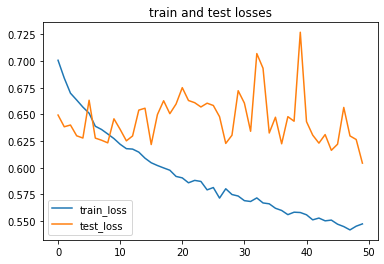

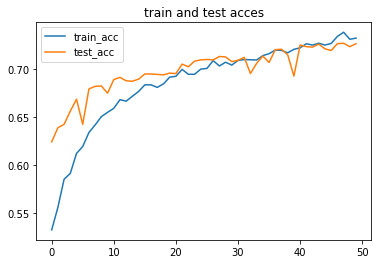

Fold = 5


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 1, Train loss 0.7136 , Train Accuracy 0.5232, Test loss 0.6635, Test Accuracy 0.6013


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 2, Train loss 0.6846 , Train Accuracy 0.5644, Test loss 0.6818, Test Accuracy 0.6009


  0%|          | 1/281 [00:00<00:34,  8.09it/s]

Epoch 3, Train loss 0.6691 , Train Accuracy 0.5910, Test loss 0.6468, Test Accuracy 0.6330


  0%|          | 1/281 [00:00<00:35,  7.84it/s]

Epoch 4, Train loss 0.6589 , Train Accuracy 0.6032, Test loss 0.6345, Test Accuracy 0.6512


  0%|          | 1/281 [00:00<00:34,  8.04it/s]

Epoch 5, Train loss 0.6545 , Train Accuracy 0.6132, Test loss 0.7746, Test Accuracy 0.5924


  0%|          | 1/281 [00:00<00:35,  7.97it/s]

Epoch 6, Train loss 0.6466 , Train Accuracy 0.6260, Test loss 0.6208, Test Accuracy 0.6788


  0%|          | 1/281 [00:00<00:34,  8.00it/s]

Epoch 7, Train loss 0.6409 , Train Accuracy 0.6342, Test loss 0.6211, Test Accuracy 0.6708


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 8, Train loss 0.6364 , Train Accuracy 0.6400, Test loss 0.6234, Test Accuracy 0.6829


  0%|          | 1/281 [00:00<00:33,  8.24it/s]

Epoch 9, Train loss 0.6294 , Train Accuracy 0.6504, Test loss 0.6251, Test Accuracy 0.6829


  0%|          | 1/281 [00:00<00:33,  8.26it/s]

Epoch 10, Train loss 0.6273 , Train Accuracy 0.6497, Test loss 0.6951, Test Accuracy 0.6584


  0%|          | 1/281 [00:00<00:34,  8.17it/s]

Epoch 11, Train loss 0.6202 , Train Accuracy 0.6652, Test loss 0.6341, Test Accuracy 0.6931


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 12, Train loss 0.6186 , Train Accuracy 0.6689, Test loss 0.6242, Test Accuracy 0.6882


  0%|          | 1/281 [00:00<00:33,  8.24it/s]

Epoch 13, Train loss 0.6106 , Train Accuracy 0.6705, Test loss 0.6497, Test Accuracy 0.6900


  0%|          | 1/281 [00:00<00:33,  8.24it/s]

Epoch 14, Train loss 0.6095 , Train Accuracy 0.6761, Test loss 0.6634, Test Accuracy 0.6846


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 15, Train loss 0.6082 , Train Accuracy 0.6771, Test loss 0.6597, Test Accuracy 0.6886


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 16, Train loss 0.5988 , Train Accuracy 0.6844, Test loss 0.6252, Test Accuracy 0.6967


  0%|          | 1/281 [00:00<00:33,  8.35it/s]

Epoch 17, Train loss 0.6052 , Train Accuracy 0.6784, Test loss 0.6148, Test Accuracy 0.7011


  0%|          | 1/281 [00:00<00:35,  7.90it/s]

Epoch 18, Train loss 0.5993 , Train Accuracy 0.6826, Test loss 0.6236, Test Accuracy 0.7029


  0%|          | 1/281 [00:00<00:33,  8.26it/s]

Epoch 19, Train loss 0.5953 , Train Accuracy 0.6897, Test loss 0.6184, Test Accuracy 0.7078


  0%|          | 1/281 [00:00<00:34,  8.06it/s]

Epoch 20, Train loss 0.5933 , Train Accuracy 0.6869, Test loss 0.6074, Test Accuracy 0.7096


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 21, Train loss 0.5893 , Train Accuracy 0.6897, Test loss 0.6185, Test Accuracy 0.7100


  0%|          | 1/281 [00:00<00:33,  8.38it/s]

Epoch 22, Train loss 0.5897 , Train Accuracy 0.6922, Test loss 0.6085, Test Accuracy 0.7163


  0%|          | 1/281 [00:00<00:35,  7.92it/s]

Epoch 23, Train loss 0.5843 , Train Accuracy 0.6977, Test loss 0.5996, Test Accuracy 0.7069


  0%|          | 1/281 [00:00<00:34,  8.04it/s]

Epoch 24, Train loss 0.5850 , Train Accuracy 0.6965, Test loss 0.6007, Test Accuracy 0.7127


  0%|          | 1/281 [00:00<00:34,  8.17it/s]

Epoch 25, Train loss 0.5821 , Train Accuracy 0.7029, Test loss 0.6347, Test Accuracy 0.6993


  0%|          | 1/281 [00:00<00:34,  8.06it/s]

Epoch 26, Train loss 0.5773 , Train Accuracy 0.7036, Test loss 0.6005, Test Accuracy 0.7158


  0%|          | 1/281 [00:00<00:34,  8.13it/s]

Epoch 27, Train loss 0.5838 , Train Accuracy 0.6948, Test loss 0.6036, Test Accuracy 0.7176


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 28, Train loss 0.5739 , Train Accuracy 0.7095, Test loss 0.5951, Test Accuracy 0.7229


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 29, Train loss 0.5716 , Train Accuracy 0.7064, Test loss 0.6290, Test Accuracy 0.7171


  0%|          | 1/281 [00:00<00:34,  8.05it/s]

Epoch 30, Train loss 0.5708 , Train Accuracy 0.7082, Test loss 0.6017, Test Accuracy 0.7167


  0%|          | 1/281 [00:00<00:33,  8.36it/s]

Epoch 31, Train loss 0.5695 , Train Accuracy 0.7125, Test loss 0.5977, Test Accuracy 0.7220


  0%|          | 1/281 [00:00<00:33,  8.28it/s]

Epoch 32, Train loss 0.5687 , Train Accuracy 0.7136, Test loss 0.5979, Test Accuracy 0.7189


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 33, Train loss 0.5703 , Train Accuracy 0.7092, Test loss 0.5974, Test Accuracy 0.7252


  0%|          | 1/281 [00:00<00:35,  7.94it/s]

Epoch 34, Train loss 0.5673 , Train Accuracy 0.7131, Test loss 0.5919, Test Accuracy 0.7274


  0%|          | 1/281 [00:00<00:34,  8.18it/s]

Epoch 35, Train loss 0.5590 , Train Accuracy 0.7226, Test loss 0.5930, Test Accuracy 0.7238


  0%|          | 1/281 [00:00<00:34,  8.19it/s]

Epoch 36, Train loss 0.5667 , Train Accuracy 0.7127, Test loss 0.5891, Test Accuracy 0.7310


  0%|          | 1/281 [00:00<00:34,  8.19it/s]

Epoch 37, Train loss 0.5588 , Train Accuracy 0.7203, Test loss 0.5961, Test Accuracy 0.7234


  0%|          | 1/281 [00:00<00:34,  8.06it/s]

Epoch 38, Train loss 0.5603 , Train Accuracy 0.7154, Test loss 0.5845, Test Accuracy 0.7278


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 39, Train loss 0.5576 , Train Accuracy 0.7200, Test loss 0.5746, Test Accuracy 0.7318


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 40, Train loss 0.5549 , Train Accuracy 0.7240, Test loss 0.5790, Test Accuracy 0.7332


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 41, Train loss 0.5569 , Train Accuracy 0.7238, Test loss 0.5816, Test Accuracy 0.7385


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 42, Train loss 0.5529 , Train Accuracy 0.7200, Test loss 0.5879, Test Accuracy 0.7323


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 43, Train loss 0.5522 , Train Accuracy 0.7223, Test loss 0.6229, Test Accuracy 0.7203


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 44, Train loss 0.5478 , Train Accuracy 0.7288, Test loss 0.5875, Test Accuracy 0.7385


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 45, Train loss 0.5506 , Train Accuracy 0.7269, Test loss 0.6289, Test Accuracy 0.7247


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 46, Train loss 0.5515 , Train Accuracy 0.7229, Test loss 0.5859, Test Accuracy 0.7381


  0%|          | 1/281 [00:00<00:34,  8.04it/s]

Epoch 47, Train loss 0.5444 , Train Accuracy 0.7289, Test loss 0.5815, Test Accuracy 0.7390


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 48, Train loss 0.5433 , Train Accuracy 0.7286, Test loss 0.5813, Test Accuracy 0.7399


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 49, Train loss 0.5394 , Train Accuracy 0.7333, Test loss 0.6538, Test Accuracy 0.7158


100%|██████████| 71/71 [00:01<00:00, 44.42it/s]


Epoch 50, Train loss 0.5446 , Train Accuracy 0.7318, Test loss 0.5970, Test Accuracy 0.7363


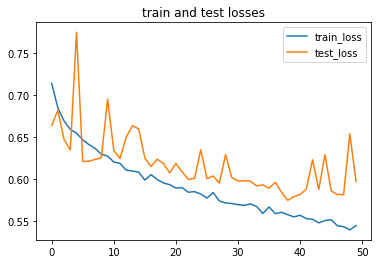

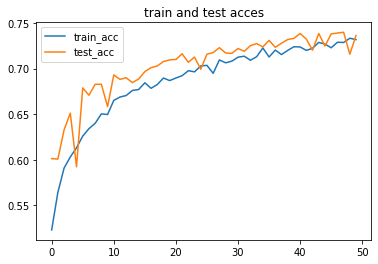

Fold 0: 0.7520035618878005 %

Fold 1: 0.7518930957683742 %

Fold 2: 0.7487750556792873 %

Fold 3: 0.7269487750556793 %

Fold 4: 0.7398663697104677 %

Average: 0.7438973716203218 %



In [102]:
train_from_sratch()

  0%|          | 1/281 [00:00<00:37,  7.42it/s]

(11226, 1, 19, 1500)
(11226, 1)
Fold = 1


  0%|          | 1/281 [00:00<00:34,  8.18it/s]

Epoch 1, Train loss 0.7107 , Train Accuracy 0.5285, Test loss 0.6526, Test Accuracy 0.6028


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 2, Train loss 0.6846 , Train Accuracy 0.5609, Test loss 0.6536, Test Accuracy 0.6011


  0%|          | 1/281 [00:00<00:34,  8.13it/s]

Epoch 3, Train loss 0.6704 , Train Accuracy 0.5787, Test loss 0.6257, Test Accuracy 0.6527


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 4, Train loss 0.6672 , Train Accuracy 0.5941, Test loss 0.6036, Test Accuracy 0.6643


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 5, Train loss 0.6516 , Train Accuracy 0.6022, Test loss 0.5880, Test Accuracy 0.6736


  0%|          | 1/281 [00:00<00:35,  7.97it/s]

Epoch 6, Train loss 0.6441 , Train Accuracy 0.6192, Test loss 0.5964, Test Accuracy 0.6990


  0%|          | 1/281 [00:00<00:33,  8.37it/s]

Epoch 7, Train loss 0.6327 , Train Accuracy 0.6347, Test loss 0.6140, Test Accuracy 0.6750


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 8, Train loss 0.6192 , Train Accuracy 0.6533, Test loss 0.5460, Test Accuracy 0.7320


  0%|          | 1/281 [00:00<00:34,  8.18it/s]

Epoch 9, Train loss 0.6153 , Train Accuracy 0.6542, Test loss 0.5522, Test Accuracy 0.7159


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 10, Train loss 0.6019 , Train Accuracy 0.6786, Test loss 0.5715, Test Accuracy 0.7382


  0%|          | 1/281 [00:00<00:34,  8.03it/s]

Epoch 11, Train loss 0.5901 , Train Accuracy 0.6851, Test loss 0.5400, Test Accuracy 0.7413


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 12, Train loss 0.5868 , Train Accuracy 0.6915, Test loss 0.5393, Test Accuracy 0.7498


  0%|          | 1/281 [00:00<00:33,  8.24it/s]

Epoch 13, Train loss 0.5797 , Train Accuracy 0.6962, Test loss 0.5378, Test Accuracy 0.7520


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 14, Train loss 0.5696 , Train Accuracy 0.7021, Test loss 0.5358, Test Accuracy 0.7591


  0%|          | 1/281 [00:00<00:33,  8.39it/s]

Epoch 15, Train loss 0.5745 , Train Accuracy 0.7052, Test loss 0.6001, Test Accuracy 0.7244


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 16, Train loss 0.5622 , Train Accuracy 0.7174, Test loss 0.5411, Test Accuracy 0.7667


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 17, Train loss 0.5540 , Train Accuracy 0.7264, Test loss 0.5398, Test Accuracy 0.7738


  0%|          | 1/281 [00:00<00:33,  8.33it/s]

Epoch 18, Train loss 0.5539 , Train Accuracy 0.7209, Test loss 0.5143, Test Accuracy 0.7756


  0%|          | 1/281 [00:00<00:35,  7.96it/s]

Epoch 19, Train loss 0.5485 , Train Accuracy 0.7248, Test loss 0.5158, Test Accuracy 0.7778


  0%|          | 1/281 [00:00<00:34,  8.13it/s]

Epoch 20, Train loss 0.5449 , Train Accuracy 0.7288, Test loss 0.5158, Test Accuracy 0.7818


  0%|          | 1/281 [00:00<00:33,  8.26it/s]

Epoch 21, Train loss 0.5340 , Train Accuracy 0.7409, Test loss 0.5220, Test Accuracy 0.7809


  0%|          | 1/281 [00:00<00:35,  7.84it/s]

Epoch 22, Train loss 0.5385 , Train Accuracy 0.7330, Test loss 0.5271, Test Accuracy 0.7867


  0%|          | 1/281 [00:00<00:33,  8.28it/s]

Epoch 23, Train loss 0.5326 , Train Accuracy 0.7411, Test loss 0.5316, Test Accuracy 0.7783


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 24, Train loss 0.5290 , Train Accuracy 0.7384, Test loss 0.5148, Test Accuracy 0.7890


  0%|          | 1/281 [00:00<00:34,  8.20it/s]

Epoch 25, Train loss 0.5263 , Train Accuracy 0.7447, Test loss 0.5117, Test Accuracy 0.7934


  0%|          | 1/281 [00:00<00:34,  8.21it/s]

Epoch 26, Train loss 0.5239 , Train Accuracy 0.7462, Test loss 0.5106, Test Accuracy 0.7916


  0%|          | 1/281 [00:00<00:34,  8.02it/s]

Epoch 27, Train loss 0.5229 , Train Accuracy 0.7496, Test loss 0.5320, Test Accuracy 0.7854


  0%|          | 1/281 [00:00<00:34,  8.05it/s]

Epoch 28, Train loss 0.5122 , Train Accuracy 0.7526, Test loss 0.5828, Test Accuracy 0.7676


  0%|          | 1/281 [00:00<00:34,  8.19it/s]

Epoch 29, Train loss 0.5194 , Train Accuracy 0.7502, Test loss 0.5169, Test Accuracy 0.7952


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 30, Train loss 0.5130 , Train Accuracy 0.7542, Test loss 0.5168, Test Accuracy 0.8014


  0%|          | 1/281 [00:00<00:34,  8.02it/s]

Epoch 31, Train loss 0.5094 , Train Accuracy 0.7577, Test loss 0.5086, Test Accuracy 0.7912


  0%|          | 1/281 [00:00<00:34,  8.09it/s]

Epoch 32, Train loss 0.5083 , Train Accuracy 0.7546, Test loss 0.4903, Test Accuracy 0.8032


  0%|          | 1/281 [00:00<00:35,  7.91it/s]

Epoch 33, Train loss 0.5074 , Train Accuracy 0.7568, Test loss 0.5216, Test Accuracy 0.7907


  0%|          | 1/281 [00:00<00:34,  8.18it/s]

Epoch 34, Train loss 0.5012 , Train Accuracy 0.7675, Test loss 0.5196, Test Accuracy 0.7947


  0%|          | 1/281 [00:00<00:33,  8.37it/s]

Epoch 35, Train loss 0.4996 , Train Accuracy 0.7651, Test loss 0.4865, Test Accuracy 0.8023


  0%|          | 1/281 [00:00<00:34,  8.06it/s]

Epoch 36, Train loss 0.4991 , Train Accuracy 0.7640, Test loss 0.4943, Test Accuracy 0.8010


  0%|          | 1/281 [00:00<00:33,  8.33it/s]

Epoch 37, Train loss 0.4968 , Train Accuracy 0.7685, Test loss 0.4977, Test Accuracy 0.8099


  0%|          | 1/281 [00:00<00:34,  8.01it/s]

Epoch 38, Train loss 0.4917 , Train Accuracy 0.7654, Test loss 0.4917, Test Accuracy 0.8126


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 39, Train loss 0.4928 , Train Accuracy 0.7699, Test loss 0.5609, Test Accuracy 0.8001


  0%|          | 1/281 [00:00<00:35,  7.90it/s]

Epoch 40, Train loss 0.4926 , Train Accuracy 0.7718, Test loss 0.5375, Test Accuracy 0.8032


  0%|          | 1/281 [00:00<00:36,  7.73it/s]

Epoch 41, Train loss 0.4864 , Train Accuracy 0.7689, Test loss 0.5400, Test Accuracy 0.7974


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 42, Train loss 0.4869 , Train Accuracy 0.7735, Test loss 0.5204, Test Accuracy 0.7939


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 43, Train loss 0.4857 , Train Accuracy 0.7753, Test loss 0.5336, Test Accuracy 0.8028


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 44, Train loss 0.4805 , Train Accuracy 0.7784, Test loss 0.4919, Test Accuracy 0.8085


  0%|          | 1/281 [00:00<00:34,  8.21it/s]

Epoch 45, Train loss 0.4787 , Train Accuracy 0.7739, Test loss 0.5313, Test Accuracy 0.8103


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 46, Train loss 0.4845 , Train Accuracy 0.7761, Test loss 0.5233, Test Accuracy 0.8126


  0%|          | 1/281 [00:00<00:34,  8.23it/s]

Epoch 47, Train loss 0.4763 , Train Accuracy 0.7785, Test loss 0.4873, Test Accuracy 0.8139


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 48, Train loss 0.4795 , Train Accuracy 0.7782, Test loss 0.5184, Test Accuracy 0.8019


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 49, Train loss 0.4722 , Train Accuracy 0.7806, Test loss 0.5304, Test Accuracy 0.8103


100%|██████████| 71/71 [00:01<00:00, 44.69it/s]


Epoch 50, Train loss 0.4768 , Train Accuracy 0.7756, Test loss 0.5290, Test Accuracy 0.8117


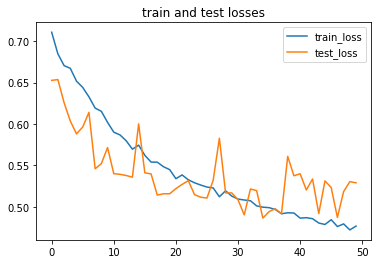

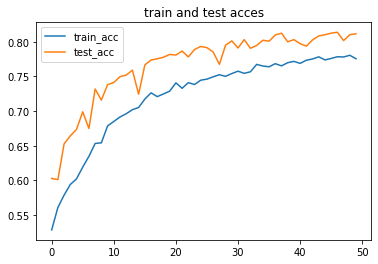

  0%|          | 0/281 [00:00<?, ?it/s]

Fold = 2


  0%|          | 1/281 [00:00<00:34,  8.23it/s]

Epoch 1, Train loss 0.6975 , Train Accuracy 0.5425, Test loss 0.6565, Test Accuracy 0.6000


  0%|          | 1/281 [00:00<00:35,  7.88it/s]

Epoch 2, Train loss 0.6697 , Train Accuracy 0.5862, Test loss 0.6600, Test Accuracy 0.6192


  0%|          | 1/281 [00:00<00:35,  7.80it/s]

Epoch 3, Train loss 0.6587 , Train Accuracy 0.5974, Test loss 0.6571, Test Accuracy 0.6236


  0%|          | 1/281 [00:00<00:33,  8.25it/s]

Epoch 4, Train loss 0.6471 , Train Accuracy 0.6185, Test loss 0.6771, Test Accuracy 0.6316


  0%|          | 1/281 [00:00<00:35,  7.96it/s]

Epoch 5, Train loss 0.6392 , Train Accuracy 0.6251, Test loss 0.7057, Test Accuracy 0.6365


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 6, Train loss 0.6375 , Train Accuracy 0.6312, Test loss 0.6624, Test Accuracy 0.6481


  0%|          | 1/281 [00:00<00:34,  8.21it/s]

Epoch 7, Train loss 0.6265 , Train Accuracy 0.6401, Test loss 0.6610, Test Accuracy 0.6610


  0%|          | 1/281 [00:00<00:34,  8.06it/s]

Epoch 8, Train loss 0.6196 , Train Accuracy 0.6480, Test loss 0.6415, Test Accuracy 0.6673


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 9, Train loss 0.6179 , Train Accuracy 0.6552, Test loss 0.6530, Test Accuracy 0.6802


  0%|          | 1/281 [00:00<00:33,  8.35it/s]

Epoch 10, Train loss 0.6090 , Train Accuracy 0.6683, Test loss 0.6615, Test Accuracy 0.6882


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 11, Train loss 0.6022 , Train Accuracy 0.6771, Test loss 0.6118, Test Accuracy 0.7033


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 12, Train loss 0.5874 , Train Accuracy 0.6905, Test loss 0.6182, Test Accuracy 0.7256


  0%|          | 1/281 [00:00<00:34,  8.18it/s]

Epoch 13, Train loss 0.5873 , Train Accuracy 0.6918, Test loss 0.5941, Test Accuracy 0.7269


  0%|          | 1/281 [00:00<00:35,  7.99it/s]

Epoch 14, Train loss 0.5749 , Train Accuracy 0.7064, Test loss 0.5786, Test Accuracy 0.7363


  0%|          | 1/281 [00:00<00:35,  7.96it/s]

Epoch 15, Train loss 0.5726 , Train Accuracy 0.7053, Test loss 0.5796, Test Accuracy 0.7443


  0%|          | 1/281 [00:00<00:35,  7.99it/s]

Epoch 16, Train loss 0.5630 , Train Accuracy 0.7156, Test loss 0.6195, Test Accuracy 0.7474


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 17, Train loss 0.5568 , Train Accuracy 0.7222, Test loss 0.5980, Test Accuracy 0.7514


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 18, Train loss 0.5513 , Train Accuracy 0.7272, Test loss 0.5764, Test Accuracy 0.7563


  0%|          | 1/281 [00:00<00:34,  8.01it/s]

Epoch 19, Train loss 0.5422 , Train Accuracy 0.7321, Test loss 0.5787, Test Accuracy 0.7644


  0%|          | 1/281 [00:00<00:33,  8.33it/s]

Epoch 20, Train loss 0.5427 , Train Accuracy 0.7297, Test loss 0.5970, Test Accuracy 0.7630


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 21, Train loss 0.5385 , Train Accuracy 0.7354, Test loss 0.6002, Test Accuracy 0.7675


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 22, Train loss 0.5315 , Train Accuracy 0.7412, Test loss 0.5741, Test Accuracy 0.7684


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 23, Train loss 0.5303 , Train Accuracy 0.7421, Test loss 0.6029, Test Accuracy 0.7697


  0%|          | 1/281 [00:00<00:34,  8.20it/s]

Epoch 24, Train loss 0.5276 , Train Accuracy 0.7432, Test loss 0.6021, Test Accuracy 0.7626


  0%|          | 1/281 [00:00<00:33,  8.34it/s]

Epoch 25, Train loss 0.5208 , Train Accuracy 0.7477, Test loss 0.5835, Test Accuracy 0.7661


  0%|          | 1/281 [00:00<00:34,  8.06it/s]

Epoch 26, Train loss 0.5172 , Train Accuracy 0.7533, Test loss 0.6666, Test Accuracy 0.7577


  0%|          | 1/281 [00:00<00:35,  7.92it/s]

Epoch 27, Train loss 0.5128 , Train Accuracy 0.7576, Test loss 0.5567, Test Accuracy 0.7733


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 28, Train loss 0.5143 , Train Accuracy 0.7513, Test loss 0.5667, Test Accuracy 0.7737


  0%|          | 1/281 [00:00<00:34,  8.20it/s]

Epoch 29, Train loss 0.5081 , Train Accuracy 0.7579, Test loss 0.5962, Test Accuracy 0.7688


  0%|          | 1/281 [00:00<00:35,  7.93it/s]

Epoch 30, Train loss 0.5057 , Train Accuracy 0.7596, Test loss 0.5647, Test Accuracy 0.7724


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 31, Train loss 0.5065 , Train Accuracy 0.7586, Test loss 0.5682, Test Accuracy 0.7813


  0%|          | 1/281 [00:00<00:34,  8.04it/s]

Epoch 32, Train loss 0.5048 , Train Accuracy 0.7586, Test loss 0.5583, Test Accuracy 0.7764


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 33, Train loss 0.5008 , Train Accuracy 0.7615, Test loss 0.5362, Test Accuracy 0.7817


  0%|          | 1/281 [00:00<00:33,  8.38it/s]

Epoch 34, Train loss 0.4967 , Train Accuracy 0.7621, Test loss 0.5962, Test Accuracy 0.7773


  0%|          | 1/281 [00:00<00:33,  8.31it/s]

Epoch 35, Train loss 0.4970 , Train Accuracy 0.7638, Test loss 0.5733, Test Accuracy 0.7777


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 36, Train loss 0.4964 , Train Accuracy 0.7675, Test loss 0.5651, Test Accuracy 0.7737


  0%|          | 1/281 [00:00<00:33,  8.35it/s]

Epoch 37, Train loss 0.4955 , Train Accuracy 0.7621, Test loss 0.5798, Test Accuracy 0.7840


  0%|          | 1/281 [00:00<00:37,  7.44it/s]

Epoch 38, Train loss 0.4848 , Train Accuracy 0.7705, Test loss 0.6489, Test Accuracy 0.7702


  0%|          | 1/281 [00:00<00:34,  8.04it/s]

Epoch 39, Train loss 0.4890 , Train Accuracy 0.7726, Test loss 0.5551, Test Accuracy 0.7902


  0%|          | 1/281 [00:00<00:34,  8.13it/s]

Epoch 40, Train loss 0.4874 , Train Accuracy 0.7732, Test loss 0.5471, Test Accuracy 0.7906


  0%|          | 1/281 [00:00<00:33,  8.29it/s]

Epoch 41, Train loss 0.4865 , Train Accuracy 0.7722, Test loss 0.5687, Test Accuracy 0.7889


  0%|          | 1/281 [00:00<00:36,  7.70it/s]

Epoch 42, Train loss 0.4844 , Train Accuracy 0.7736, Test loss 0.5988, Test Accuracy 0.7764


  0%|          | 1/281 [00:00<00:36,  7.77it/s]

Epoch 43, Train loss 0.4806 , Train Accuracy 0.7764, Test loss 0.6455, Test Accuracy 0.7693


  0%|          | 1/281 [00:00<00:34,  8.20it/s]

Epoch 44, Train loss 0.4787 , Train Accuracy 0.7745, Test loss 0.5658, Test Accuracy 0.7911


  0%|          | 1/281 [00:00<00:33,  8.33it/s]

Epoch 45, Train loss 0.4747 , Train Accuracy 0.7793, Test loss 0.5412, Test Accuracy 0.7947


  0%|          | 1/281 [00:00<00:33,  8.30it/s]

Epoch 46, Train loss 0.4766 , Train Accuracy 0.7811, Test loss 0.5864, Test Accuracy 0.7831


  0%|          | 1/281 [00:00<00:34,  8.05it/s]

Epoch 47, Train loss 0.4740 , Train Accuracy 0.7799, Test loss 0.5459, Test Accuracy 0.7982


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 48, Train loss 0.4698 , Train Accuracy 0.7811, Test loss 0.5472, Test Accuracy 0.7978


  0%|          | 1/281 [00:00<00:33,  8.32it/s]

Epoch 49, Train loss 0.4736 , Train Accuracy 0.7812, Test loss 0.5516, Test Accuracy 0.7875


100%|██████████| 71/71 [00:01<00:00, 44.67it/s]


Epoch 50, Train loss 0.4721 , Train Accuracy 0.7850, Test loss 0.5280, Test Accuracy 0.7947


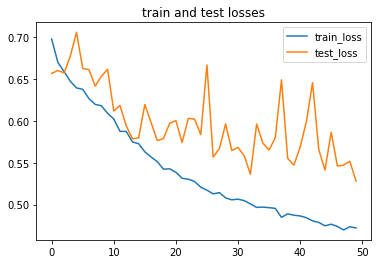

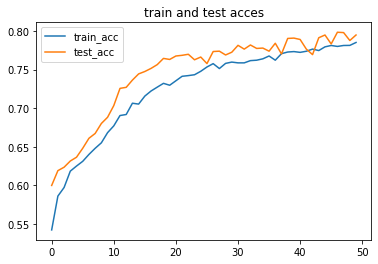

  0%|          | 0/281 [00:00<?, ?it/s]

Fold = 3


  0%|          | 1/281 [00:00<00:34,  8.23it/s]

Epoch 1, Train loss 0.7004 , Train Accuracy 0.5400, Test loss 0.7299, Test Accuracy 0.5626


  0%|          | 1/281 [00:00<00:33,  8.29it/s]

Epoch 2, Train loss 0.6801 , Train Accuracy 0.5641, Test loss 0.6735, Test Accuracy 0.5733


  0%|          | 1/281 [00:00<00:34,  8.18it/s]

Epoch 3, Train loss 0.6735 , Train Accuracy 0.5762, Test loss 0.6708, Test Accuracy 0.6031


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 4, Train loss 0.6666 , Train Accuracy 0.5877, Test loss 0.6387, Test Accuracy 0.6160


  0%|          | 1/281 [00:00<00:34,  8.23it/s]

Epoch 5, Train loss 0.6613 , Train Accuracy 0.5930, Test loss 0.6345, Test Accuracy 0.6227


  0%|          | 1/281 [00:00<00:34,  8.20it/s]

Epoch 6, Train loss 0.6554 , Train Accuracy 0.6004, Test loss 0.6160, Test Accuracy 0.6388


  0%|          | 1/281 [00:00<00:33,  8.26it/s]

Epoch 7, Train loss 0.6459 , Train Accuracy 0.6157, Test loss 0.6153, Test Accuracy 0.6521


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 8, Train loss 0.6401 , Train Accuracy 0.6216, Test loss 0.6204, Test Accuracy 0.6650


  0%|          | 1/281 [00:00<00:34,  8.01it/s]

Epoch 9, Train loss 0.6317 , Train Accuracy 0.6398, Test loss 0.5957, Test Accuracy 0.6940


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 10, Train loss 0.6231 , Train Accuracy 0.6525, Test loss 0.5667, Test Accuracy 0.7261


  0%|          | 1/281 [00:00<00:34,  8.19it/s]

Epoch 11, Train loss 0.6114 , Train Accuracy 0.6646, Test loss 0.5505, Test Accuracy 0.7345


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 12, Train loss 0.6035 , Train Accuracy 0.6722, Test loss 0.5388, Test Accuracy 0.7443


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 13, Train loss 0.5961 , Train Accuracy 0.6819, Test loss 0.5536, Test Accuracy 0.7626


  0%|          | 1/281 [00:00<00:33,  8.32it/s]

Epoch 14, Train loss 0.5830 , Train Accuracy 0.6900, Test loss 0.6098, Test Accuracy 0.7238


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 15, Train loss 0.5769 , Train Accuracy 0.7072, Test loss 0.5509, Test Accuracy 0.7559


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 16, Train loss 0.5704 , Train Accuracy 0.7076, Test loss 0.5307, Test Accuracy 0.7675


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 17, Train loss 0.5627 , Train Accuracy 0.7153, Test loss 0.5345, Test Accuracy 0.7661


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 18, Train loss 0.5587 , Train Accuracy 0.7132, Test loss 0.5468, Test Accuracy 0.7719


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 19, Train loss 0.5505 , Train Accuracy 0.7272, Test loss 0.5805, Test Accuracy 0.7572


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 20, Train loss 0.5500 , Train Accuracy 0.7269, Test loss 0.5854, Test Accuracy 0.7581


  0%|          | 1/281 [00:00<00:35,  7.82it/s]

Epoch 21, Train loss 0.5429 , Train Accuracy 0.7300, Test loss 0.5345, Test Accuracy 0.7759


  0%|          | 1/281 [00:00<00:34,  8.19it/s]

Epoch 22, Train loss 0.5378 , Train Accuracy 0.7338, Test loss 0.5432, Test Accuracy 0.7751


  0%|          | 1/281 [00:00<00:33,  8.28it/s]

Epoch 23, Train loss 0.5347 , Train Accuracy 0.7417, Test loss 0.5738, Test Accuracy 0.7702


  0%|          | 1/281 [00:00<00:37,  7.52it/s]

Epoch 24, Train loss 0.5316 , Train Accuracy 0.7412, Test loss 0.5406, Test Accuracy 0.7844


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 25, Train loss 0.5310 , Train Accuracy 0.7417, Test loss 0.5655, Test Accuracy 0.7777


  0%|          | 1/281 [00:00<00:34,  8.02it/s]

Epoch 26, Train loss 0.5297 , Train Accuracy 0.7464, Test loss 0.5292, Test Accuracy 0.7866


  0%|          | 1/281 [00:00<00:34,  8.03it/s]

Epoch 27, Train loss 0.5202 , Train Accuracy 0.7501, Test loss 0.5352, Test Accuracy 0.7800


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 28, Train loss 0.5171 , Train Accuracy 0.7504, Test loss 0.5342, Test Accuracy 0.7871


  0%|          | 1/281 [00:00<00:33,  8.25it/s]

Epoch 29, Train loss 0.5193 , Train Accuracy 0.7507, Test loss 0.5790, Test Accuracy 0.7702


  0%|          | 1/281 [00:00<00:35,  7.97it/s]

Epoch 30, Train loss 0.5130 , Train Accuracy 0.7526, Test loss 0.5416, Test Accuracy 0.7929


  0%|          | 1/281 [00:00<00:34,  8.00it/s]

Epoch 31, Train loss 0.5123 , Train Accuracy 0.7526, Test loss 0.5498, Test Accuracy 0.7710


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 32, Train loss 0.5079 , Train Accuracy 0.7553, Test loss 0.5627, Test Accuracy 0.7942


  0%|          | 1/281 [00:00<00:33,  8.28it/s]

Epoch 33, Train loss 0.5115 , Train Accuracy 0.7555, Test loss 0.5479, Test Accuracy 0.7933


  0%|          | 1/281 [00:00<00:34,  8.04it/s]

Epoch 34, Train loss 0.5109 , Train Accuracy 0.7534, Test loss 0.5572, Test Accuracy 0.7835


  0%|          | 1/281 [00:00<00:34,  8.18it/s]

Epoch 35, Train loss 0.5032 , Train Accuracy 0.7618, Test loss 0.5618, Test Accuracy 0.7782


  0%|          | 1/281 [00:00<00:35,  7.96it/s]

Epoch 36, Train loss 0.5042 , Train Accuracy 0.7619, Test loss 0.5227, Test Accuracy 0.7929


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 37, Train loss 0.4942 , Train Accuracy 0.7661, Test loss 0.5600, Test Accuracy 0.7880


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 38, Train loss 0.4972 , Train Accuracy 0.7626, Test loss 0.5200, Test Accuracy 0.8000


  0%|          | 1/281 [00:00<00:33,  8.35it/s]

Epoch 39, Train loss 0.4961 , Train Accuracy 0.7633, Test loss 0.5387, Test Accuracy 0.7929


  0%|          | 1/281 [00:00<00:33,  8.28it/s]

Epoch 40, Train loss 0.5003 , Train Accuracy 0.7644, Test loss 0.5182, Test Accuracy 0.7947


  0%|          | 1/281 [00:00<00:34,  8.19it/s]

Epoch 41, Train loss 0.4963 , Train Accuracy 0.7677, Test loss 0.5184, Test Accuracy 0.7991


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 42, Train loss 0.4961 , Train Accuracy 0.7670, Test loss 0.5158, Test Accuracy 0.7996


  0%|          | 1/281 [00:00<00:33,  8.37it/s]

Epoch 43, Train loss 0.4903 , Train Accuracy 0.7685, Test loss 0.5069, Test Accuracy 0.8071


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 44, Train loss 0.4917 , Train Accuracy 0.7697, Test loss 0.5229, Test Accuracy 0.8000


  0%|          | 1/281 [00:00<00:34,  8.05it/s]

Epoch 45, Train loss 0.4888 , Train Accuracy 0.7685, Test loss 0.5172, Test Accuracy 0.8018


  0%|          | 1/281 [00:00<00:33,  8.35it/s]

Epoch 46, Train loss 0.4848 , Train Accuracy 0.7750, Test loss 0.5024, Test Accuracy 0.8049


  0%|          | 1/281 [00:00<00:34,  8.04it/s]

Epoch 47, Train loss 0.4806 , Train Accuracy 0.7719, Test loss 0.5093, Test Accuracy 0.7996


  0%|          | 1/281 [00:00<00:35,  7.82it/s]

Epoch 48, Train loss 0.4812 , Train Accuracy 0.7776, Test loss 0.5032, Test Accuracy 0.8094


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 49, Train loss 0.4809 , Train Accuracy 0.7736, Test loss 0.5069, Test Accuracy 0.8053


100%|██████████| 71/71 [00:01<00:00, 45.03it/s]


Epoch 50, Train loss 0.4910 , Train Accuracy 0.7735, Test loss 0.4993, Test Accuracy 0.8013


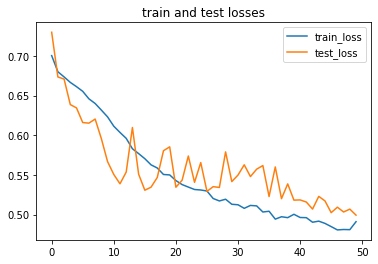

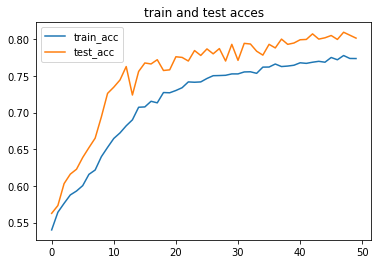

  0%|          | 0/281 [00:00<?, ?it/s]

Fold = 4


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 1, Train loss 0.6999 , Train Accuracy 0.5399, Test loss 0.6907, Test Accuracy 0.5871


  0%|          | 1/281 [00:00<00:35,  7.82it/s]

Epoch 2, Train loss 0.6739 , Train Accuracy 0.5705, Test loss 0.6561, Test Accuracy 0.6027


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 3, Train loss 0.6628 , Train Accuracy 0.5915, Test loss 0.6823, Test Accuracy 0.6245


  0%|          | 1/281 [00:00<00:33,  8.29it/s]

Epoch 4, Train loss 0.6505 , Train Accuracy 0.6140, Test loss 0.6138, Test Accuracy 0.6530


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 5, Train loss 0.6361 , Train Accuracy 0.6388, Test loss 0.6721, Test Accuracy 0.6463


  0%|          | 1/281 [00:00<00:33,  8.26it/s]

Epoch 6, Train loss 0.6280 , Train Accuracy 0.6444, Test loss 0.6216, Test Accuracy 0.6940


  0%|          | 1/281 [00:00<00:33,  8.38it/s]

Epoch 7, Train loss 0.6156 , Train Accuracy 0.6587, Test loss 0.6089, Test Accuracy 0.7114


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 8, Train loss 0.6041 , Train Accuracy 0.6685, Test loss 0.5845, Test Accuracy 0.7212


  0%|          | 1/281 [00:00<00:34,  8.05it/s]

Epoch 9, Train loss 0.5882 , Train Accuracy 0.6880, Test loss 0.5768, Test Accuracy 0.7350


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 10, Train loss 0.5791 , Train Accuracy 0.6977, Test loss 0.6047, Test Accuracy 0.7403


  0%|          | 1/281 [00:00<00:35,  7.97it/s]

Epoch 11, Train loss 0.5693 , Train Accuracy 0.7023, Test loss 0.5708, Test Accuracy 0.7474


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 12, Train loss 0.5653 , Train Accuracy 0.7094, Test loss 0.5738, Test Accuracy 0.7532


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 13, Train loss 0.5541 , Train Accuracy 0.7255, Test loss 0.5701, Test Accuracy 0.7617


  0%|          | 1/281 [00:00<00:33,  8.32it/s]

Epoch 14, Train loss 0.5476 , Train Accuracy 0.7272, Test loss 0.5699, Test Accuracy 0.7590


  0%|          | 1/281 [00:00<00:33,  8.32it/s]

Epoch 15, Train loss 0.5460 , Train Accuracy 0.7288, Test loss 0.5656, Test Accuracy 0.7608


  0%|          | 1/281 [00:00<00:33,  8.27it/s]

Epoch 16, Train loss 0.5418 , Train Accuracy 0.7317, Test loss 0.5659, Test Accuracy 0.7635


  0%|          | 1/281 [00:00<00:33,  8.24it/s]

Epoch 17, Train loss 0.5378 , Train Accuracy 0.7367, Test loss 0.5651, Test Accuracy 0.7657


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 18, Train loss 0.5285 , Train Accuracy 0.7407, Test loss 0.5632, Test Accuracy 0.7604


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 19, Train loss 0.5338 , Train Accuracy 0.7392, Test loss 0.5563, Test Accuracy 0.7728


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 20, Train loss 0.5288 , Train Accuracy 0.7415, Test loss 0.5838, Test Accuracy 0.7697


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 21, Train loss 0.5252 , Train Accuracy 0.7432, Test loss 0.5675, Test Accuracy 0.7742


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 22, Train loss 0.5158 , Train Accuracy 0.7507, Test loss 0.5753, Test Accuracy 0.7737


  0%|          | 1/281 [00:00<00:35,  7.99it/s]

Epoch 23, Train loss 0.5158 , Train Accuracy 0.7505, Test loss 0.5595, Test Accuracy 0.7751


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 24, Train loss 0.5132 , Train Accuracy 0.7535, Test loss 0.5616, Test Accuracy 0.7795


  0%|          | 1/281 [00:00<00:34,  8.02it/s]

Epoch 25, Train loss 0.5124 , Train Accuracy 0.7536, Test loss 0.5570, Test Accuracy 0.7795


  0%|          | 1/281 [00:00<00:34,  8.08it/s]

Epoch 26, Train loss 0.5133 , Train Accuracy 0.7569, Test loss 0.5675, Test Accuracy 0.7764


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 27, Train loss 0.5090 , Train Accuracy 0.7570, Test loss 0.5294, Test Accuracy 0.7871


  0%|          | 1/281 [00:00<00:34,  8.20it/s]

Epoch 28, Train loss 0.4997 , Train Accuracy 0.7622, Test loss 0.5594, Test Accuracy 0.7871


  0%|          | 1/281 [00:00<00:35,  7.91it/s]

Epoch 29, Train loss 0.5059 , Train Accuracy 0.7626, Test loss 0.6332, Test Accuracy 0.7546


  0%|          | 1/281 [00:00<00:34,  8.21it/s]

Epoch 30, Train loss 0.4991 , Train Accuracy 0.7652, Test loss 0.5356, Test Accuracy 0.7906


  0%|          | 1/281 [00:00<00:34,  8.23it/s]

Epoch 31, Train loss 0.4942 , Train Accuracy 0.7656, Test loss 0.5416, Test Accuracy 0.7902


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 32, Train loss 0.4918 , Train Accuracy 0.7727, Test loss 0.5371, Test Accuracy 0.7862


  0%|          | 1/281 [00:00<00:34,  8.03it/s]

Epoch 33, Train loss 0.4956 , Train Accuracy 0.7675, Test loss 0.5255, Test Accuracy 0.7893


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 34, Train loss 0.4872 , Train Accuracy 0.7710, Test loss 0.5239, Test Accuracy 0.7938


  0%|          | 1/281 [00:00<00:33,  8.42it/s]

Epoch 35, Train loss 0.4831 , Train Accuracy 0.7715, Test loss 0.5193, Test Accuracy 0.7906


  0%|          | 1/281 [00:00<00:34,  8.16it/s]

Epoch 36, Train loss 0.4893 , Train Accuracy 0.7708, Test loss 0.5216, Test Accuracy 0.7942


  0%|          | 1/281 [00:00<00:33,  8.26it/s]

Epoch 37, Train loss 0.4824 , Train Accuracy 0.7678, Test loss 0.5227, Test Accuracy 0.7933


  0%|          | 1/281 [00:00<00:33,  8.29it/s]

Epoch 38, Train loss 0.4841 , Train Accuracy 0.7712, Test loss 0.5730, Test Accuracy 0.7826


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 39, Train loss 0.4765 , Train Accuracy 0.7789, Test loss 0.5862, Test Accuracy 0.7853


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 40, Train loss 0.4783 , Train Accuracy 0.7730, Test loss 0.5421, Test Accuracy 0.7915


  0%|          | 1/281 [00:00<00:34,  8.04it/s]

Epoch 41, Train loss 0.4829 , Train Accuracy 0.7762, Test loss 0.5363, Test Accuracy 0.7960


  0%|          | 1/281 [00:00<00:35,  7.99it/s]

Epoch 42, Train loss 0.4768 , Train Accuracy 0.7783, Test loss 0.5259, Test Accuracy 0.7929


  0%|          | 1/281 [00:00<00:33,  8.30it/s]

Epoch 43, Train loss 0.4706 , Train Accuracy 0.7837, Test loss 0.5085, Test Accuracy 0.7969


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 44, Train loss 0.4715 , Train Accuracy 0.7784, Test loss 0.5114, Test Accuracy 0.7955


  0%|          | 1/281 [00:00<00:34,  8.18it/s]

Epoch 45, Train loss 0.4678 , Train Accuracy 0.7801, Test loss 0.5161, Test Accuracy 0.7951


  0%|          | 1/281 [00:00<00:33,  8.33it/s]

Epoch 46, Train loss 0.4685 , Train Accuracy 0.7838, Test loss 0.5061, Test Accuracy 0.7960


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 47, Train loss 0.4650 , Train Accuracy 0.7860, Test loss 0.4975, Test Accuracy 0.8009


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 48, Train loss 0.4606 , Train Accuracy 0.7907, Test loss 0.5036, Test Accuracy 0.8031


  0%|          | 1/281 [00:00<00:34,  8.10it/s]

Epoch 49, Train loss 0.4585 , Train Accuracy 0.7873, Test loss 0.4920, Test Accuracy 0.7996


100%|██████████| 71/71 [00:01<00:00, 43.99it/s]


Epoch 50, Train loss 0.4575 , Train Accuracy 0.7869, Test loss 0.5358, Test Accuracy 0.8009


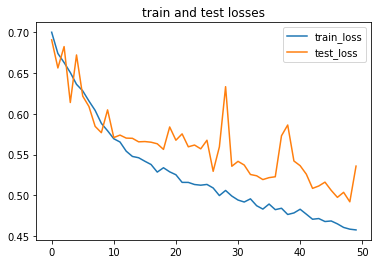

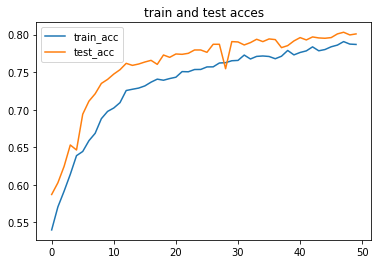

  0%|          | 0/281 [00:00<?, ?it/s]

Fold = 5


  0%|          | 1/281 [00:00<00:35,  7.82it/s]

Epoch 1, Train loss 0.7022 , Train Accuracy 0.5379, Test loss 0.6781, Test Accuracy 0.5666


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 2, Train loss 0.6810 , Train Accuracy 0.5603, Test loss 0.6691, Test Accuracy 0.6045


  0%|          | 1/281 [00:00<00:34,  8.23it/s]

Epoch 3, Train loss 0.6699 , Train Accuracy 0.5822, Test loss 0.6479, Test Accuracy 0.6374


  0%|          | 1/281 [00:00<00:34,  8.04it/s]

Epoch 4, Train loss 0.6605 , Train Accuracy 0.6016, Test loss 0.6269, Test Accuracy 0.6352


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 5, Train loss 0.6525 , Train Accuracy 0.6097, Test loss 0.6184, Test Accuracy 0.6557


  0%|          | 1/281 [00:00<00:34,  8.22it/s]

Epoch 6, Train loss 0.6448 , Train Accuracy 0.6239, Test loss 0.6051, Test Accuracy 0.6726


  0%|          | 1/281 [00:00<00:33,  8.42it/s]

Epoch 7, Train loss 0.6355 , Train Accuracy 0.6274, Test loss 0.6685, Test Accuracy 0.6521


  0%|          | 1/281 [00:00<00:34,  8.12it/s]

Epoch 8, Train loss 0.6200 , Train Accuracy 0.6494, Test loss 0.6045, Test Accuracy 0.6980


  0%|          | 1/281 [00:00<00:36,  7.72it/s]

Epoch 9, Train loss 0.6081 , Train Accuracy 0.6644, Test loss 0.6110, Test Accuracy 0.7033


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 10, Train loss 0.5990 , Train Accuracy 0.6742, Test loss 0.5883, Test Accuracy 0.7220


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 11, Train loss 0.5880 , Train Accuracy 0.6867, Test loss 0.6898, Test Accuracy 0.6860


  0%|          | 1/281 [00:00<00:34,  8.23it/s]

Epoch 12, Train loss 0.5858 , Train Accuracy 0.6917, Test loss 0.6329, Test Accuracy 0.7114


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 13, Train loss 0.5791 , Train Accuracy 0.6974, Test loss 0.5874, Test Accuracy 0.7412


  0%|          | 1/281 [00:00<00:33,  8.39it/s]

Epoch 14, Train loss 0.5678 , Train Accuracy 0.7085, Test loss 0.6301, Test Accuracy 0.7194


  0%|          | 1/281 [00:00<00:34,  8.06it/s]

Epoch 15, Train loss 0.5661 , Train Accuracy 0.7102, Test loss 0.5975, Test Accuracy 0.7376


  0%|          | 1/281 [00:00<00:34,  8.00it/s]

Epoch 16, Train loss 0.5607 , Train Accuracy 0.7141, Test loss 0.5934, Test Accuracy 0.7376


  0%|          | 1/281 [00:00<00:33,  8.31it/s]

Epoch 17, Train loss 0.5555 , Train Accuracy 0.7142, Test loss 0.6729, Test Accuracy 0.7212


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 18, Train loss 0.5540 , Train Accuracy 0.7207, Test loss 0.5701, Test Accuracy 0.7448


  0%|          | 1/281 [00:00<00:34,  8.06it/s]

Epoch 19, Train loss 0.5508 , Train Accuracy 0.7278, Test loss 0.5712, Test Accuracy 0.7492


  0%|          | 1/281 [00:00<00:33,  8.24it/s]

Epoch 20, Train loss 0.5479 , Train Accuracy 0.7254, Test loss 0.5944, Test Accuracy 0.7506


  0%|          | 1/281 [00:00<00:34,  8.19it/s]

Epoch 21, Train loss 0.5419 , Train Accuracy 0.7293, Test loss 0.5754, Test Accuracy 0.7528


  0%|          | 1/281 [00:00<00:33,  8.30it/s]

Epoch 22, Train loss 0.5419 , Train Accuracy 0.7396, Test loss 0.5726, Test Accuracy 0.7546


  0%|          | 1/281 [00:00<00:34,  8.19it/s]

Epoch 23, Train loss 0.5376 , Train Accuracy 0.7343, Test loss 0.5751, Test Accuracy 0.7528


  0%|          | 1/281 [00:00<00:34,  8.23it/s]

Epoch 24, Train loss 0.5381 , Train Accuracy 0.7352, Test loss 0.5878, Test Accuracy 0.7595


  0%|          | 1/281 [00:00<00:33,  8.24it/s]

Epoch 25, Train loss 0.5315 , Train Accuracy 0.7421, Test loss 0.6278, Test Accuracy 0.7550


  0%|          | 1/281 [00:00<00:33,  8.42it/s]

Epoch 26, Train loss 0.5342 , Train Accuracy 0.7420, Test loss 0.5551, Test Accuracy 0.7635


  0%|          | 1/281 [00:00<00:33,  8.26it/s]

Epoch 27, Train loss 0.5297 , Train Accuracy 0.7458, Test loss 0.5661, Test Accuracy 0.7635


  0%|          | 1/281 [00:00<00:34,  8.17it/s]

Epoch 28, Train loss 0.5245 , Train Accuracy 0.7441, Test loss 0.5959, Test Accuracy 0.7586


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 29, Train loss 0.5204 , Train Accuracy 0.7540, Test loss 0.6081, Test Accuracy 0.7599


  0%|          | 1/281 [00:00<00:33,  8.34it/s]

Epoch 30, Train loss 0.5174 , Train Accuracy 0.7514, Test loss 0.5640, Test Accuracy 0.7706


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 31, Train loss 0.5173 , Train Accuracy 0.7544, Test loss 0.5767, Test Accuracy 0.7679


  0%|          | 1/281 [00:00<00:33,  8.35it/s]

Epoch 32, Train loss 0.5190 , Train Accuracy 0.7475, Test loss 0.5657, Test Accuracy 0.7684


  0%|          | 1/281 [00:00<00:34,  8.13it/s]

Epoch 33, Train loss 0.5172 , Train Accuracy 0.7517, Test loss 0.5620, Test Accuracy 0.7706


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 34, Train loss 0.5151 , Train Accuracy 0.7570, Test loss 0.5569, Test Accuracy 0.7768


  0%|          | 1/281 [00:00<00:34,  8.14it/s]

Epoch 35, Train loss 0.5130 , Train Accuracy 0.7562, Test loss 0.5509, Test Accuracy 0.7728


  0%|          | 1/281 [00:00<00:33,  8.29it/s]

Epoch 36, Train loss 0.5046 , Train Accuracy 0.7616, Test loss 0.6012, Test Accuracy 0.7670


  0%|          | 1/281 [00:00<00:33,  8.33it/s]

Epoch 37, Train loss 0.5067 , Train Accuracy 0.7598, Test loss 0.5522, Test Accuracy 0.7768


  0%|          | 1/281 [00:00<00:34,  8.15it/s]

Epoch 38, Train loss 0.5049 , Train Accuracy 0.7594, Test loss 0.5657, Test Accuracy 0.7777


  0%|          | 1/281 [00:00<00:33,  8.32it/s]

Epoch 39, Train loss 0.5016 , Train Accuracy 0.7683, Test loss 0.5630, Test Accuracy 0.7795


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch 40, Train loss 0.4994 , Train Accuracy 0.7697, Test loss 0.5533, Test Accuracy 0.7844


  0%|          | 1/281 [00:00<00:34,  8.20it/s]

Epoch 41, Train loss 0.4980 , Train Accuracy 0.7671, Test loss 0.6452, Test Accuracy 0.7541


  0%|          | 1/281 [00:00<00:33,  8.41it/s]

Epoch 42, Train loss 0.4950 , Train Accuracy 0.7663, Test loss 0.5679, Test Accuracy 0.7813


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 43, Train loss 0.5042 , Train Accuracy 0.7569, Test loss 0.5397, Test Accuracy 0.7866


  0%|          | 1/281 [00:00<00:33,  8.30it/s]

Epoch 44, Train loss 0.4907 , Train Accuracy 0.7730, Test loss 0.5377, Test Accuracy 0.7884


  0%|          | 1/281 [00:00<00:33,  8.35it/s]

Epoch 45, Train loss 0.4906 , Train Accuracy 0.7716, Test loss 0.5607, Test Accuracy 0.7884


  0%|          | 1/281 [00:00<00:34,  8.06it/s]

Epoch 46, Train loss 0.4853 , Train Accuracy 0.7757, Test loss 0.5343, Test Accuracy 0.7884


  0%|          | 1/281 [00:00<00:35,  7.99it/s]

Epoch 47, Train loss 0.4886 , Train Accuracy 0.7696, Test loss 0.5450, Test Accuracy 0.7849


  0%|          | 1/281 [00:00<00:34,  8.07it/s]

Epoch 48, Train loss 0.4830 , Train Accuracy 0.7737, Test loss 0.5615, Test Accuracy 0.7889


  0%|          | 1/281 [00:00<00:34,  8.11it/s]

Epoch 49, Train loss 0.4846 , Train Accuracy 0.7770, Test loss 0.5245, Test Accuracy 0.7955


100%|██████████| 71/71 [00:01<00:00, 44.84it/s]


Epoch 50, Train loss 0.4882 , Train Accuracy 0.7737, Test loss 0.5375, Test Accuracy 0.7951


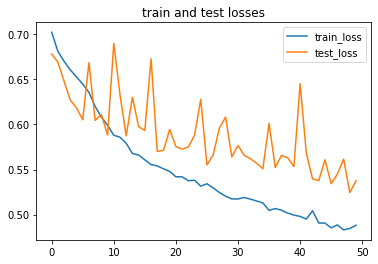

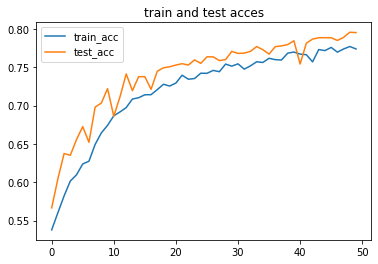

Fold 0: 0.8138913624220837 %

Fold 1: 0.7982182628062361 %

Fold 2: 0.8093541202672606 %

Fold 3: 0.8031180400890868 %

Fold 4: 0.7955456570155902 %

Average: 0.8040254885200515 %



In [103]:
transfer_learning()

### Example 2: compare the transfer learning results on an extrame small set of TUH Normal/Abnormal dataset.

In [1]:
# Compare the results with train from scratch 

In [42]:
# define some training settings
batch_size = 16
num_workers = 8
epochs = 20
learning_rate = 5e-5
model_path = './examples_res/tuh_all_ckp.pt'
train_normal_filename_path = './examples_res/small_normal_train.txt'
train_abnormal_filename_path = './examples_res/small_abnormal_train.txt'
test_normal_filename_path = './examples_res/small_normal_test.txt'
test_abnormal_filename_path = './examples_res/small_abnormal_test.txt'
layers_to_transfer = 3
layers_to_freeze = 1
folds = 5

In [43]:
def transfer_learning():
    
    #Load Dataset
    train_dataset = TUH_Normal_Abnormal(normal_filename=train_normal_filename_path, abnormal_filename =train_abnormal_filename_path)
    test_dataset = TUH_Normal_Abnormal(normal_filename=test_normal_filename_path, abnormal_filename =test_abnormal_filename_path)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
           
    #Initial model 
    model = Supervised_TUH()

    #Load pre-trained parameters
    pretrained_dict = torch.load(model_path) 
    pretrained_param_names = list(pretrained_dict.keys())
    model_dict = model.state_dict()
    model_param_names = list(model_dict.keys())

    # Load the first three layers' parameters
    # Note: One layer here corresponds to 4 layers in the model, they are  ... layers
    for i, _ in enumerate(pretrained_param_names[:layers_to_transfer * 4]):
        model_dict[model_param_names[i]] = pretrained_dict[pretrained_param_names[i]]
    
    model.load_state_dict(model_dict)

    #freeze the first few layers
    for i, (name, param) in enumerate(model.named_parameters()):
        if i < layers_to_freeze * 4 and param.requires_grad:
            print(f'freezed {name}')
            param.requires_grad = False
            continue
        print(name)
        
    model.to(device)

    train_losses, test_losses, train_acces, test_acces = train_test_loop(train_loader, test_loader, model, n_epochs=epochs, lr=learning_rate)
    _plot_losses(train_losses, test_losses)
    _plot_acces(train_acces, test_acces)

In [44]:
def train_from_scratch():
    #Load Dataset
    train_dataset = TUH_Normal_Abnormal(normal_filename=train_normal_filename_path, abnormal_filename =train_abnormal_filename_path)
    test_dataset = TUH_Normal_Abnormal(normal_filename=test_normal_filename_path, abnormal_filename =test_abnormal_filename_path)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
           
    #Initial model 
    model = Supervised_TUH()
    
    model.to(device)

    train_losses, test_losses, train_acces, test_acces = train_test_loop(train_loader, test_loader, model, n_epochs=epochs, lr=learning_rate)
    _plot_losses(train_losses, test_losses)
    _plot_acces(train_acces, test_acces)

  0%|          | 0/5 [00:00<?, ?it/s]

(1837, 1, 19, 1500)
(1837, 1)


  0%|          | 0/115 [00:00<?, ?it/s]

(1898, 1, 19, 1500)
(1898, 1)
freezed feature_extractor.encoder.Encoder_0.0.weight
freezed feature_extractor.encoder.Encoder_0.0.bias
freezed feature_extractor.encoder.Encoder_0.2.weight
freezed feature_extractor.encoder.Encoder_0.2.bias
feature_extractor.encoder.Encoder_1.0.weight
feature_extractor.encoder.Encoder_1.0.bias
feature_extractor.encoder.Encoder_1.2.weight
feature_extractor.encoder.Encoder_1.2.bias
feature_extractor.encoder.Encoder_2.0.weight
feature_extractor.encoder.Encoder_2.0.bias
feature_extractor.encoder.Encoder_2.2.weight
feature_extractor.encoder.Encoder_2.2.bias
feature_extractor.encoder.Encoder_3.0.weight
feature_extractor.encoder.Encoder_3.0.bias
feature_extractor.encoder.Encoder_3.2.weight
feature_extractor.encoder.Encoder_3.2.bias
feature_extractor.encoder.Encoder_4.0.weight
feature_extractor.encoder.Encoder_4.0.bias
feature_extractor.encoder.Encoder_4.2.weight
feature_extractor.encoder.Encoder_4.2.bias
feature_extractor.encoder.Encoder_5.0.weight
feature_extra

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 1, Train loss 0.7464 , Train Accuracy 0.4976, Test loss 0.7061, Test Accuracy 0.5316


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2, Train loss 0.7085 , Train Accuracy 0.5264, Test loss 0.7067, Test Accuracy 0.5321


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3, Train loss 0.6914 , Train Accuracy 0.5536, Test loss 0.7419, Test Accuracy 0.5279


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4, Train loss 0.6762 , Train Accuracy 0.5885, Test loss 0.7009, Test Accuracy 0.5601


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5, Train loss 0.6706 , Train Accuracy 0.6004, Test loss 0.6969, Test Accuracy 0.5717


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 6, Train loss 0.6611 , Train Accuracy 0.6179, Test loss 0.7049, Test Accuracy 0.5632


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 7, Train loss 0.6507 , Train Accuracy 0.6108, Test loss 0.7791, Test Accuracy 0.5416


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 8, Train loss 0.6544 , Train Accuracy 0.6168, Test loss 0.7302, Test Accuracy 0.5743


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 9, Train loss 0.6600 , Train Accuracy 0.6124, Test loss 0.7479, Test Accuracy 0.5701


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 10, Train loss 0.6349 , Train Accuracy 0.6440, Test loss 0.7193, Test Accuracy 0.5574


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 11, Train loss 0.6330 , Train Accuracy 0.6456, Test loss 0.7366, Test Accuracy 0.5796


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 12, Train loss 0.6098 , Train Accuracy 0.6745, Test loss 0.8732, Test Accuracy 0.5495


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 13, Train loss 0.6142 , Train Accuracy 0.6603, Test loss 0.8116, Test Accuracy 0.5638


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 14, Train loss 0.6144 , Train Accuracy 0.6696, Test loss 0.8572, Test Accuracy 0.5611


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 15, Train loss 0.6021 , Train Accuracy 0.6788, Test loss 0.8267, Test Accuracy 0.5701


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 16, Train loss 0.5939 , Train Accuracy 0.6864, Test loss 0.7637, Test Accuracy 0.5817


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 17, Train loss 0.5894 , Train Accuracy 0.6962, Test loss 0.8400, Test Accuracy 0.5753


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 18, Train loss 0.5863 , Train Accuracy 0.6826, Test loss 0.7954, Test Accuracy 0.5848


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 19, Train loss 0.5868 , Train Accuracy 0.6826, Test loss 0.7907, Test Accuracy 0.5806


100%|██████████| 119/119 [00:01<00:00, 62.31it/s]


Epoch 20, Train loss 0.5710 , Train Accuracy 0.7115, Test loss 1.1164, Test Accuracy 0.5369


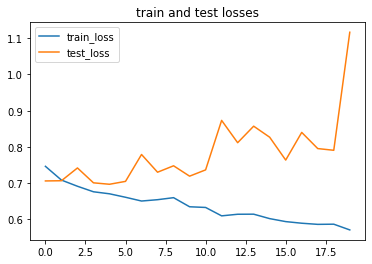

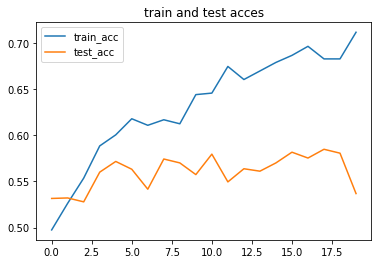

In [51]:
transfer_learning()

  0%|          | 0/5 [00:00<?, ?it/s]

(1837, 1, 19, 1500)
(1837, 1)


  0%|          | 0/115 [00:00<?, ?it/s]

(1898, 1, 19, 1500)
(1898, 1)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 1, Train loss 0.7209 , Train Accuracy 0.5427, Test loss 0.7133, Test Accuracy 0.5432


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2, Train loss 0.6783 , Train Accuracy 0.5874, Test loss 0.8369, Test Accuracy 0.5095


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3, Train loss 0.6665 , Train Accuracy 0.6200, Test loss 0.8046, Test Accuracy 0.5443


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4, Train loss 0.6513 , Train Accuracy 0.6233, Test loss 0.8267, Test Accuracy 0.5616


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5, Train loss 0.6572 , Train Accuracy 0.6157, Test loss 0.9300, Test Accuracy 0.4995


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 6, Train loss 0.6382 , Train Accuracy 0.6380, Test loss 0.9841, Test Accuracy 0.4905


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 7, Train loss 0.6223 , Train Accuracy 0.6407, Test loss 0.9559, Test Accuracy 0.5227


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 8, Train loss 0.6269 , Train Accuracy 0.6418, Test loss 1.0594, Test Accuracy 0.4953


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 9, Train loss 0.6293 , Train Accuracy 0.6489, Test loss 1.0143, Test Accuracy 0.5100


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 10, Train loss 0.6273 , Train Accuracy 0.6500, Test loss 1.0545, Test Accuracy 0.5126


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 11, Train loss 0.6167 , Train Accuracy 0.6549, Test loss 1.0249, Test Accuracy 0.5190


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 12, Train loss 0.6088 , Train Accuracy 0.6810, Test loss 1.0137, Test Accuracy 0.5321


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 13, Train loss 0.6140 , Train Accuracy 0.6581, Test loss 1.0191, Test Accuracy 0.5348


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 14, Train loss 0.6049 , Train Accuracy 0.6614, Test loss 1.0829, Test Accuracy 0.5148


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 15, Train loss 0.5995 , Train Accuracy 0.6832, Test loss 1.0698, Test Accuracy 0.5116


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 16, Train loss 0.6044 , Train Accuracy 0.6723, Test loss 1.0709, Test Accuracy 0.5200


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 17, Train loss 0.5899 , Train Accuracy 0.6919, Test loss 1.0711, Test Accuracy 0.5285


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 18, Train loss 0.5859 , Train Accuracy 0.6864, Test loss 1.1680, Test Accuracy 0.5068


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 19, Train loss 0.5800 , Train Accuracy 0.6903, Test loss 1.0991, Test Accuracy 0.5227


100%|██████████| 119/119 [00:01<00:00, 62.41it/s]


Epoch 20, Train loss 0.5798 , Train Accuracy 0.6962, Test loss 1.2969, Test Accuracy 0.4779


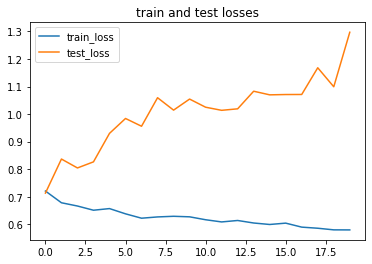

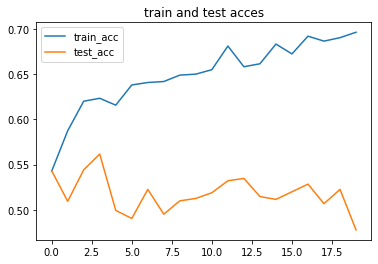

In [48]:
train_from_scratch()

Training from scratch on such small dataset, the model is quickly over-fitted and performs random results on the testing set. But if load the first few layers' parameters of the pre-trained feature extractor and freeze some layers' parameters, the downstream classifier can still classify the test set to some degree. 

Since the training set is too small and the testing results are easy to be affected by different model initialization, we do the experiments on multiple training sets and compute the average accuracy to reduce biad.  

More downstram transfer learning results can be found in the folder ./example_res/tuh_tf_results 

We conduct transfer learning on three different small training sets, and test on one testing set. We tried different combinations of numbers of layers to transfer and different layers to freeze. The plot results can be found in the folder ./images